In [1]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
directory = "/scratch/pp2681/mom6/Apr2023/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

In [4]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2023/GZ21_results', additional_subfolder='')

In [5]:
directory = "/scratch/pp2681/mom6/CM26_Double_Gyre/generalization"
for name in os.listdir(directory):
    ds += CollectionOfExperiments.init_folder(os.path.join(directory,name), additional_subfolder='output', prefix=name)

Error, cannot find files in folder/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-FCT-3-test/output


In [6]:
len(ds.exps)

844

In [7]:
for exp in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', exp)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


# Generalization

In [8]:
def sample_ssh(exp, target):
    
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            sample.append(
                Lk_error(ds[exp].ea.isel(zi=0).sel(Time=idx).mean('Time'), ds[target].ssh_mean)[0]
            )
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [9]:
def error_ssh(exp, target):
    return Lk_error(ds[exp].ssh_mean,ds[target].ssh_mean)[0]

In [10]:
def sample_KE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            u = ds[exp].u.sel(Time=idx)
            v = ds[exp].v.sel(Time=idx)
            h = ds[exp].h.sel(Time=idx)
    
            KE = 1e-15 * ds[exp].KE_joul(u, v, h).mean('Time').sum()
            sample.append(KE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [11]:
def KE(exp, target=None):
    return 1e-15 * (ds[exp].MKE_joul + ds[exp].EKE_joul).sum('zl').values

In [12]:
def sample_APE(exp, target=None):
    sample = []
    for year_start in [5, 10, 15]:
        try:
            year_end = year_start + 5
            idx = slice(365*year_start, 365*year_end)
            e = ds[exp].e.sel(Time=idx)
            APE = 1e-15 * (
                ds[exp].PE_joul(e).mean('Time').sum() + 
                ds[exp].PE_ssh(e).mean('Time').sum()
            )
            sample.append(APE)
        except:
            sample.append(np.nan)
    return xr.DataArray(sample, dims='sample')

In [13]:
def APE(exp, target=None):
    return 1e-15 * (ds[exp].MPE_joul + ds[exp].EPE_joul + ds[exp].MPE_ssh + ds[exp].EPE_ssh).values

# New plotter of APE/KE metrics

In [14]:
error = {}

In [15]:
%%time
for fun, fun_str in zip([sample_KE, sample_APE, sample_ssh], ['KE', 'APE', 'ssh']):
    error[f'bare-{fun_str}'] = xr.concat([fun(conf,f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error[f'ZB-Smooth-{fun_str}'] = xr.concat([fun(f'ZB-Smooth-{conf}-ZB-1.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error[f'Jansen-Held-{fun_str}'] = xr.concat([fun(f'Jansen-Held-{conf}-ref', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 52 s, sys: 7.89 s, total: 59.9 s
Wall time: 49.7 s


In [16]:
%%time
for fun, fun_str in zip([sample_KE, sample_APE, sample_ssh], ['KE', 'APE', 'ssh']):
    error[f'ANN-Nov-{fun_str}'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-Cs-0.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    error[f'ANN-FCT-Mar-{fun_str}'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-FCT-3', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')    

CPU times: user 38.3 s, sys: 6.57 s, total: 44.8 s
Wall time: 30.9 s


In [17]:
%%time
for fun, fun_str in zip([sample_KE, sample_APE, sample_ssh], ['KE', 'APE', 'ssh']):
    %time error[f'ANN-Nov-{fun_str}'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-Cs-0.0', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')
    %time error[f'ANN-FCT-Mar-{fun_str}'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-FCT-3', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')    
    %time error[f'ANN-smag-Mar-{fun_str}'] = xr.concat([fun(f'ANN_CM26_grid_harmonic_ver3-{conf}-ZB-1.0-Cs-0.06', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 11.3 s, sys: 1.1 s, total: 12.4 s
Wall time: 9.56 s
CPU times: user 11.5 s, sys: 1.14 s, total: 12.6 s
Wall time: 8.72 s
CPU times: user 13.3 s, sys: 2 s, total: 15.3 s
Wall time: 9.52 s
CPU times: user 3.29 s, sys: 505 ms, total: 3.8 s
Wall time: 5.05 s
CPU times: user 3.33 s, sys: 425 ms, total: 3.75 s
Wall time: 5.23 s
CPU times: user 3.31 s, sys: 430 ms, total: 3.74 s
Wall time: 3.33 s
CPU times: user 956 ms, sys: 168 ms, total: 1.12 s
Wall time: 4.98 s
CPU times: user 913 ms, sys: 231 ms, total: 1.14 s
Wall time: 2.8 s
CPU times: user 2.94 s, sys: 940 ms, total: 3.88 s
Wall time: 3.19 s
CPU times: user 50.9 s, sys: 6.93 s, total: 57.8 s
Wall time: 52.4 s


In [18]:
%%time
for fun, fun_str in zip([sample_KE, sample_APE, sample_ssh], ['KE', 'APE', 'ssh']):
    for postfix in ['inviscid', 'FCT-0', 'FCT-0-Cs-0.00', 'FCT-0-Cs-0.01', 'FCT-0-Cs-0.03', 'FCT-3', 'FCT-3-low', 'FCT-3-medium', 'FCT-3-small', 'Cs-0.06', 'Cs-0.03', 'Cs-0.01', 'Cs-0.00']:
        for exp in ['EXP2', 'EXP3']:
            %time error[f'{exp}-{postfix}-{fun_str}'] = xr.concat([fun(f'May16-{exp}-{conf}-ZB-1.0-{postfix}', f'R64_{conf}') for conf in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']], dim='res')

CPU times: user 12.3 s, sys: 1.93 s, total: 14.3 s
Wall time: 8.65 s
CPU times: user 13.6 s, sys: 1.86 s, total: 15.5 s
Wall time: 9.74 s
CPU times: user 13.7 s, sys: 1.85 s, total: 15.5 s
Wall time: 9.78 s
CPU times: user 13.1 s, sys: 1.85 s, total: 14.9 s
Wall time: 9.25 s
CPU times: user 13.6 s, sys: 1.75 s, total: 15.4 s
Wall time: 9.79 s
CPU times: user 13 s, sys: 1.87 s, total: 14.8 s
Wall time: 9.16 s
CPU times: user 13.5 s, sys: 1.89 s, total: 15.4 s
Wall time: 9.88 s
CPU times: user 13 s, sys: 1.84 s, total: 14.9 s
Wall time: 9.14 s
CPU times: user 14 s, sys: 1.88 s, total: 15.9 s
Wall time: 10.2 s
CPU times: user 13 s, sys: 1.85 s, total: 14.9 s
Wall time: 9.22 s
CPU times: user 12.9 s, sys: 1.82 s, total: 14.7 s
Wall time: 9.09 s
CPU times: user 13.6 s, sys: 1.86 s, total: 15.5 s
Wall time: 10 s
CPU times: user 12.9 s, sys: 1.81 s, total: 14.7 s
Wall time: 9.11 s
CPU times: user 13.8 s, sys: 1.86 s, total: 15.6 s
Wall time: 9.85 s
CPU times: user 13.1 s, sys: 1.67 s, total: 

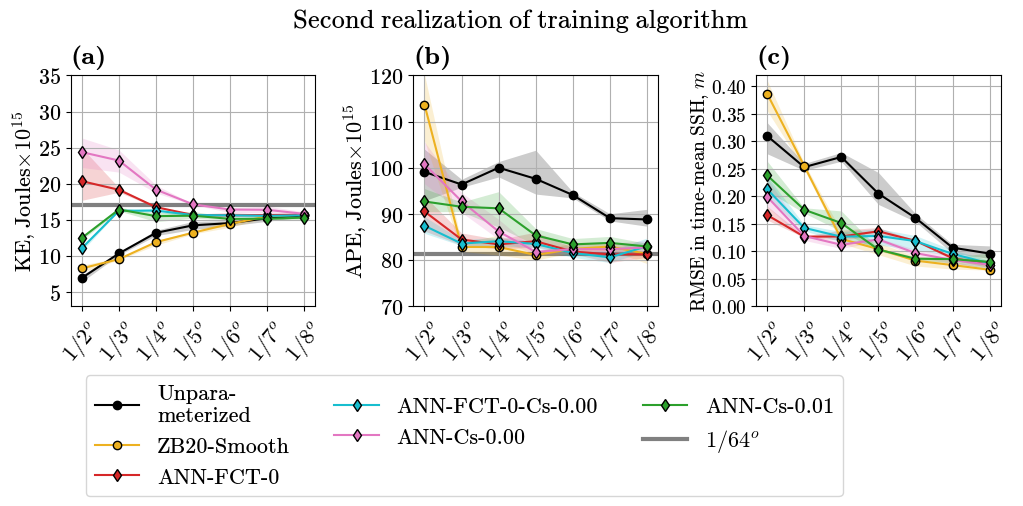

In [42]:
default_rcParams({'font.size': 16, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
plt.figure(figsize=(12,3))

yellow = [0.9290, 0.6940, 0.1250]
violet = [0.4940, 0.1840, 0.5560]
lightblue = [0.3010, 0.7450, 0.9330]

for row, fun_str in enumerate(['KE', 'APE', 'ssh']):
    plt.subplot(1,3,row+1)

    def plot_markers_with_filling(model='Jansen-Held', color='tab:red', marker='s', label=None, markersize=None, lw=None):
        error[model].mean('sample').plot(color=color, marker=marker, label=label, markersize=markersize, markeredgecolor='k', lw=lw)
        plt.fill_between(range(7), error[model].min('sample'), error[model].max('sample'), color=color, alpha=0.2, lw=0)
    
    plot_markers_with_filling(f'bare-{fun_str}', 'k', 'o', 'Unpara-\nmeterized', 6)
    plot_markers_with_filling(f'ZB-Smooth-{fun_str}', yellow, 'o', 'ZB20-Smooth', 6)
    #plot_markers_with_filling(f'EXP2-inviscid-{fun_str}', yellow, 'd', 'ANN-inviscid', 6)
    #plot_markers_with_filling(f'EXP3-inviscid-{fun_str}', yellow, 'd', 'ANN-inviscid', 6)

    #plot_markers_with_filling(f'EXP2-FCT-0-{fun_str}', 'tab:red', 'd', 'ANN-FCT-0', 6)
    plot_markers_with_filling(f'EXP3-FCT-0-{fun_str}', 'tab:red', 'd', 'ANN-FCT-0', 6)

    #plot_markers_with_filling(f'EXP2-FCT-0-Cs-0.00-{fun_str}', 'tab:cyan', 'd', 'ANN-FCT-0-Cs-0.00', 6)
    plot_markers_with_filling(f'EXP3-FCT-0-Cs-0.00-{fun_str}', 'tab:cyan', 'd', 'ANN-FCT-0-Cs-0.00', 6)

    #plot_markers_with_filling(f'EXP2-FCT-0-Cs-0.01-{fun_str}', 'tab:orange', 'd', 'ANN-FCT-0-Cs-0.01', 6)
    #plot_markers_with_filling(f'EXP3-FCT-0-Cs-0.01-{fun_str}', 'tab:orange', 'd', 'ANN-FCT-0-Cs-0.01', 6)

    #plot_markers_with_filling(f'EXP3-FCT-0-Cs-0.03-{fun_str}', 'tab:cyan', 'd', 'ANN-FCT-0-Cs-0.03', 6)

    #plot_markers_with_filling(f'EXP2-Cs-0.00-{fun_str}', 'tab:pink', 'd', 'ANN-Cs-0.00', 6)
    plot_markers_with_filling(f'EXP3-Cs-0.00-{fun_str}', 'tab:pink', 'd', 'ANN-Cs-0.00', 6)

    #plot_markers_with_filling(f'EXP2-Cs-0.01-{fun_str}', 'tab:green', 'd', 'ANN-Cs-0.01', 6)
    plot_markers_with_filling(f'EXP3-Cs-0.01-{fun_str}', 'tab:green', 'd', 'ANN-Cs-0.01', 6)

    # plot_markers_with_filling(f'EXP2-Cs-0.03-{fun_str}', 'tab:red', 'd', 'ANN-Cs-0.03', 6)
    # plot_markers_with_filling(f'EXP3-Cs-0.03-{fun_str}', 'tab:red', 's', 'ANN-Cs-0.03', 6)

    # plot_markers_with_filling(f'EXP2-Cs-0.06-{fun_str}', 'tab:blue', 'd', 'ANN-Cs-0.06', 6)
    # plot_markers_with_filling(f'EXP3-Cs-0.06-{fun_str}', 'tab:blue', 's', 'ANN-Cs-0.06', 6)

    #plot_markers_with_filling(f'EXP2-FCT-3-{fun_str}', violet, 'd', 'ANN-FCT-3', 6)
    #plot_markers_with_filling(f'EXP3-FCT-3-{fun_str}', violet, 'd', 'ANN-FCT-3', 6)

    #plot_markers_with_filling(f'EXP2-FCT-3-medium-{fun_str}', 'tab:orange', 'd', 'ANN-FCT-3-medium', 6)
    #plot_markers_with_filling(f'EXP3-FCT-3-medium-{fun_str}', 'tab:orange', 'd', 'ANN-FCT-3-medium', 6)

    #plot_markers_with_filling(f'EXP2-FCT-3-small-{fun_str}', 'tab:pink', 'd', 'ANN-FCT-3-small', 6)
    # plot_markers_with_filling(f'EXP3-FCT-3-small-{fun_str}', 'tab:pink', 's', 'ANN-FCT-3-small', 6)

    #plot_markers_with_filling(f'EXP2-FCT-3-low-{fun_str}', 'tab:olive', 'd', 'ANN-FCT-3-low', 6)
    #plot_markers_with_filling(f'EXP3-FCT-3-low-{fun_str}', 'tab:olive', 's', 'ANN-FCT-3-low', 6)
    
    plt.xticks([0,1,2,3,4,5,6], ['$1/2^o$', '$1/3^o$', '$1/4^o$', '$1/5^o$', '$1/6^o$', '$1/7^o$', '$1/8^o$'],rotation=50)    
    plt.grid()
    plt.xlabel('')
    if fun_str == 'KE':
        yticks = np.arange(5,40,5)
        plt.ylabel('KE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([3,35])
        plt.axhline(y=KE('R64'),color='gray', zorder=-1,lw=3)
        #plt.text(0.0, 17.5,'$1/64^o$', color='gray')
    if fun_str == 'APE':
        yticks = np.arange(70,130,10)
        plt.ylabel('APE, Joules$\\times10^{15}$')
        plt.yticks(yticks)
        plt.ylim([min(yticks), max(yticks)])
        plt.axhline(y=APE('R64'),color='gray',zorder=-1,lw=3)
    
    if fun_str == 'ssh':
        yticks = np.arange(0,0.45,0.05)
        plt.ylabel('RMSE in time-mean SSH, $m$', fontsize=14)
        plt.yticks(yticks, fontsize=14)
        plt.ylim([0,0.42])

plt.gcf().align_ylabels()
set_letters(fontsize=18,x=0.0,y=1.05)
plt.plot(np.nan,np.nan,'-',color='gray',lw=3,label='$1/64^o$')
plt.legend(ncol=3, bbox_to_anchor=(0.4,-0.25))


plt.suptitle('Second realization of training algorithm', y=1.1)
plt.savefig('../figures/16May/ANN-2-new-limiters.pdf')

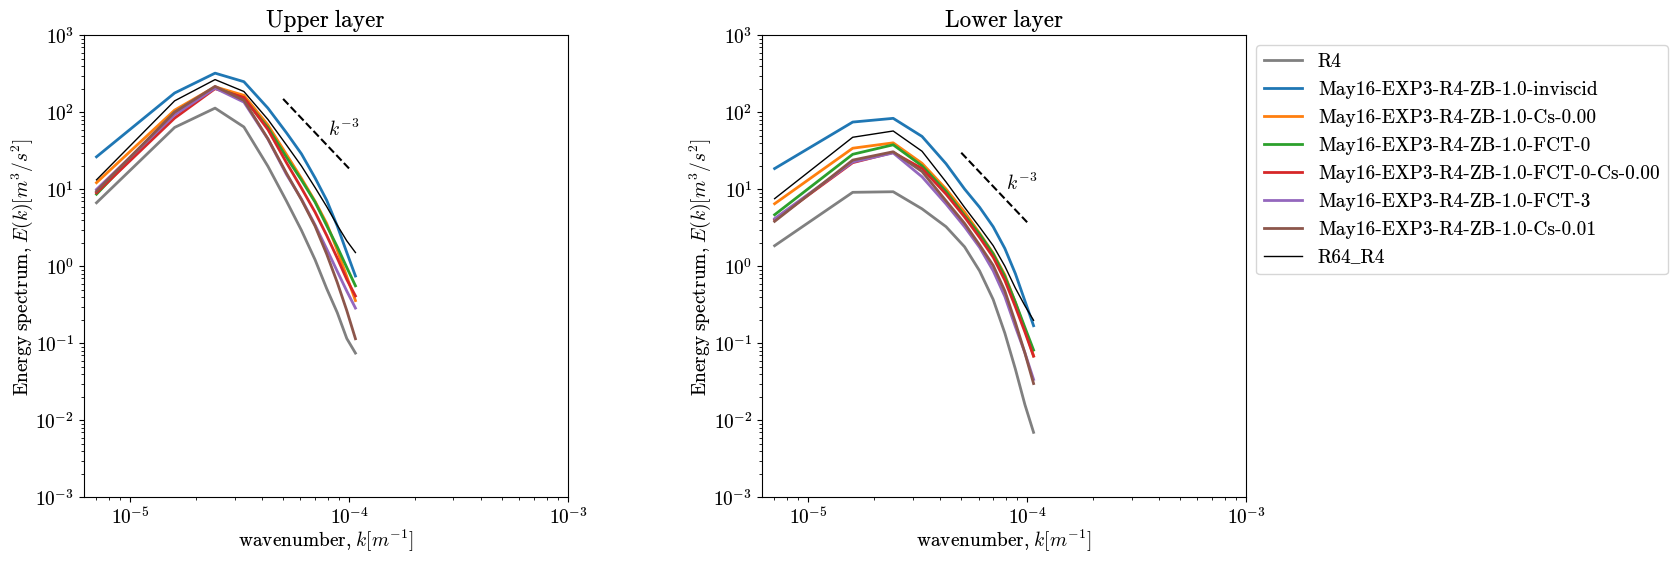

In [48]:
RR = 'R4'
default_rcParams({'font.size': 14, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_spectrum([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

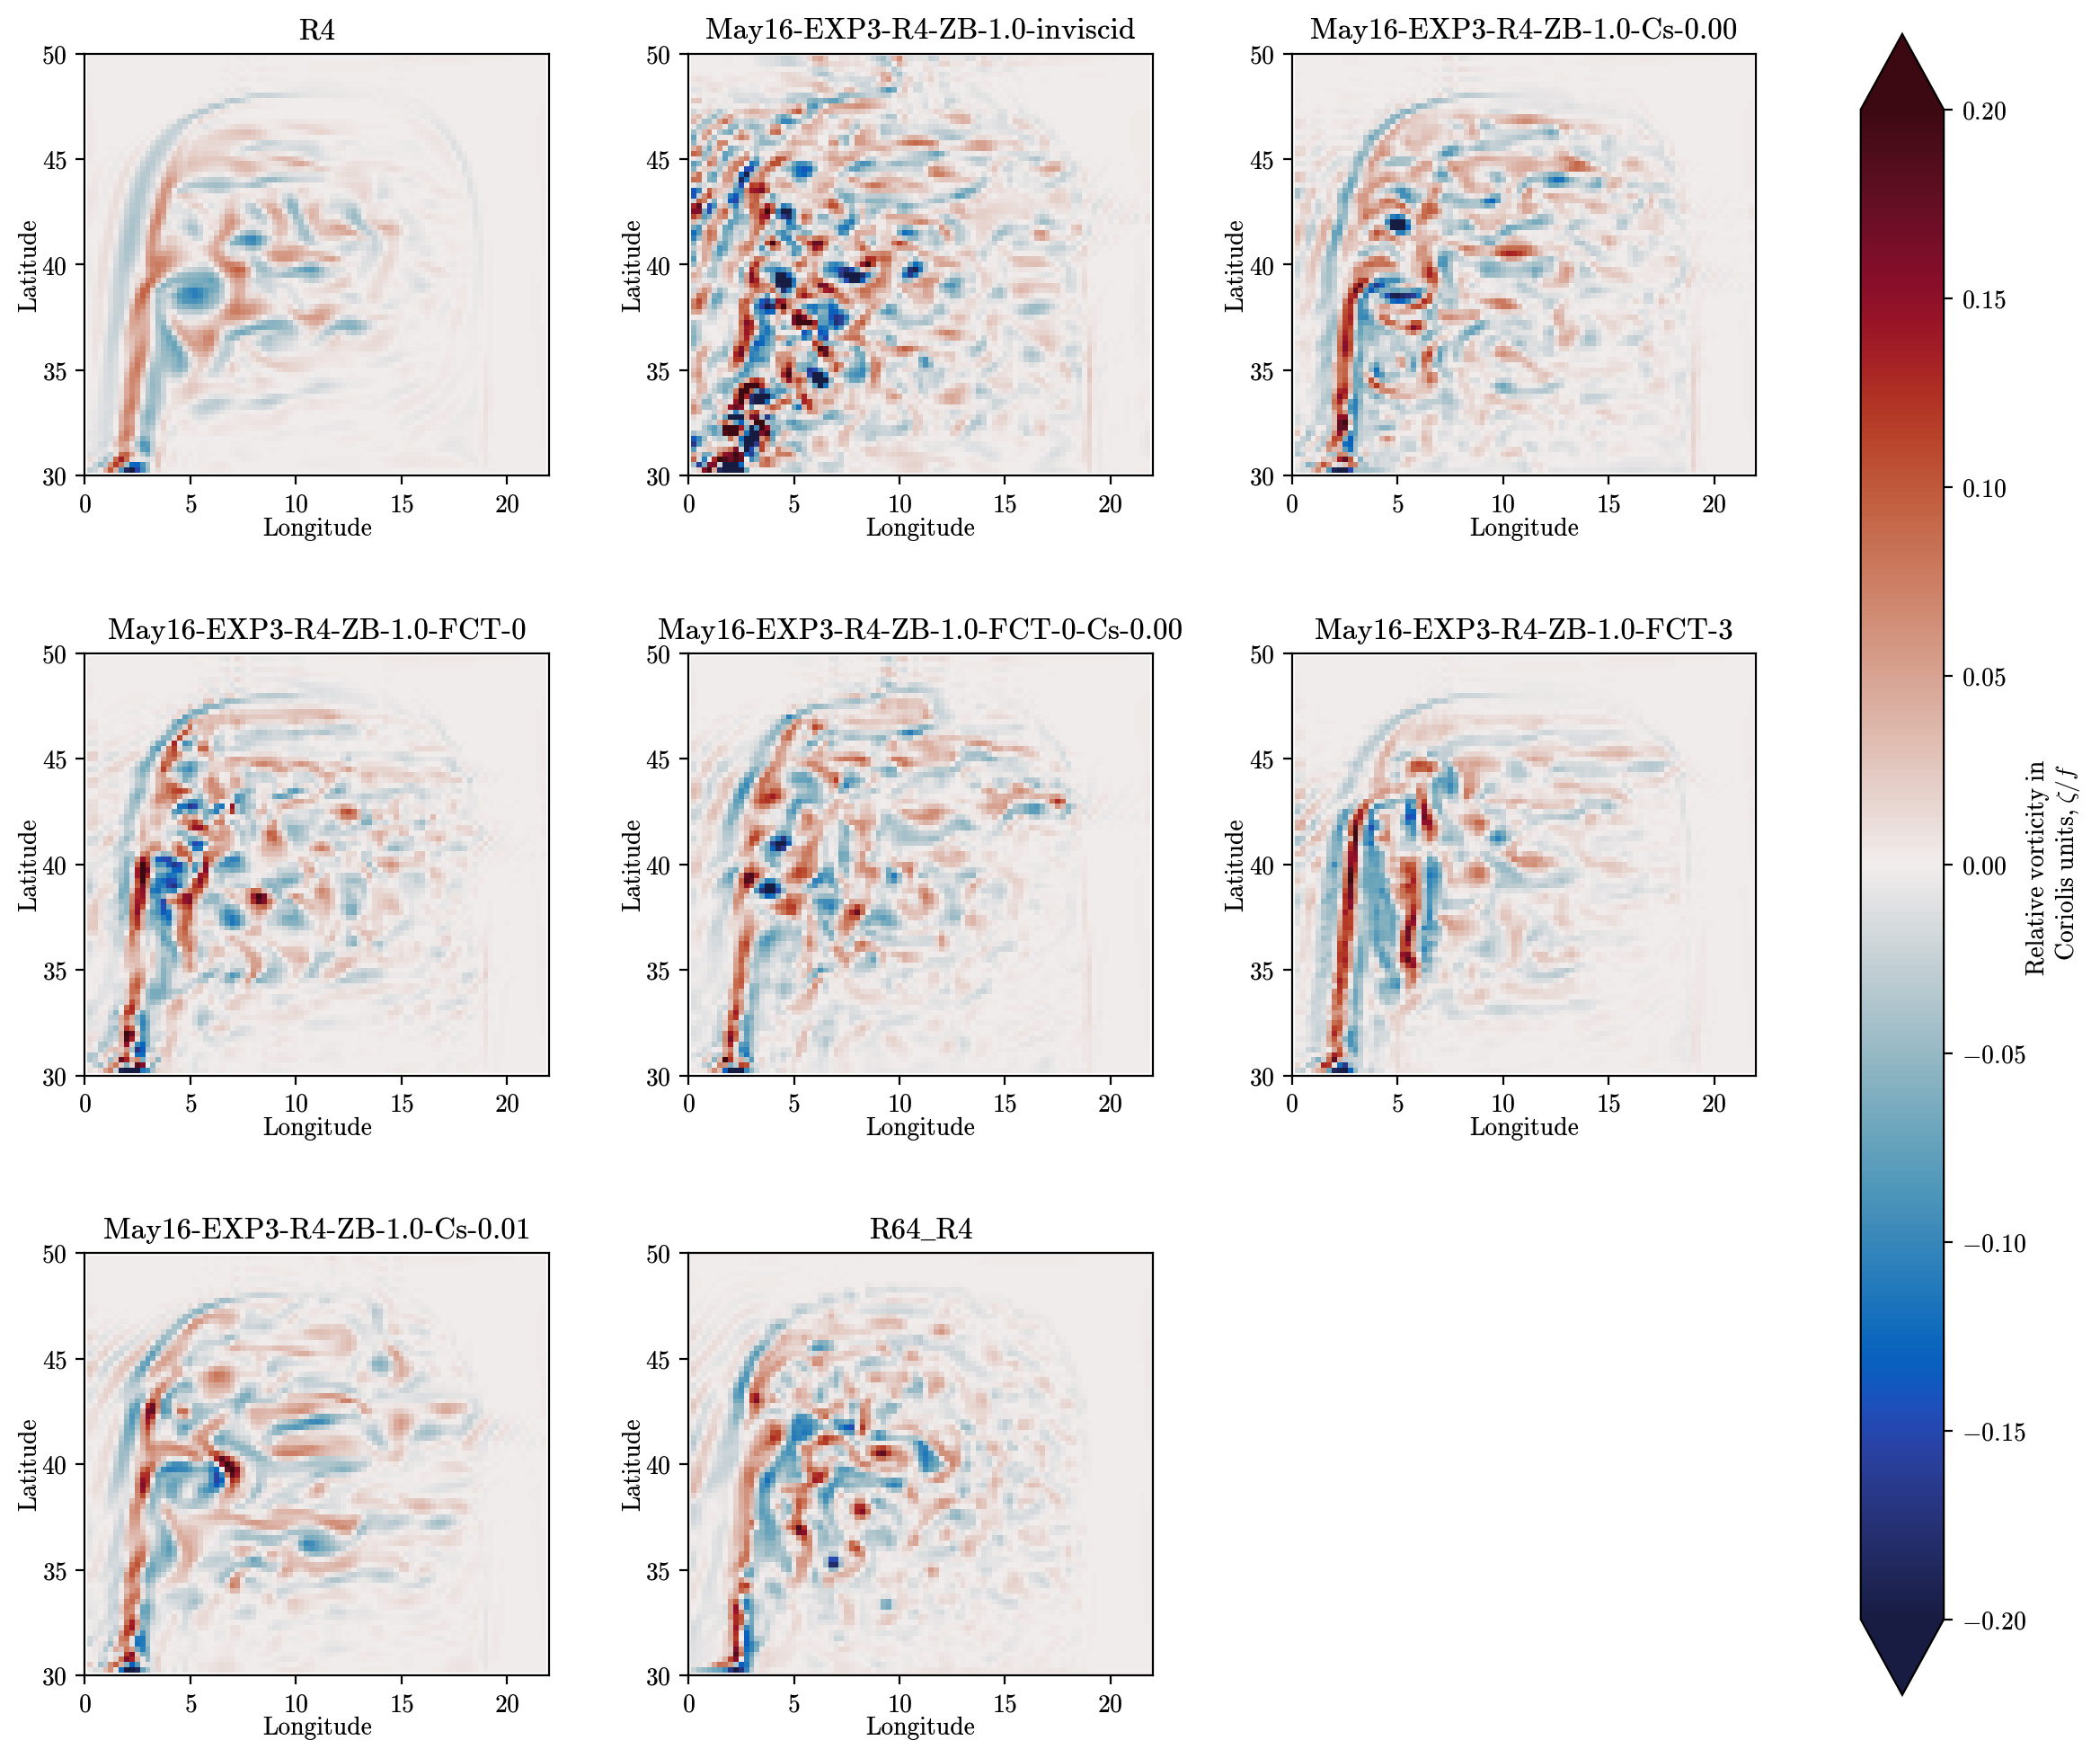

In [50]:
RR = 'R4'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_RV([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

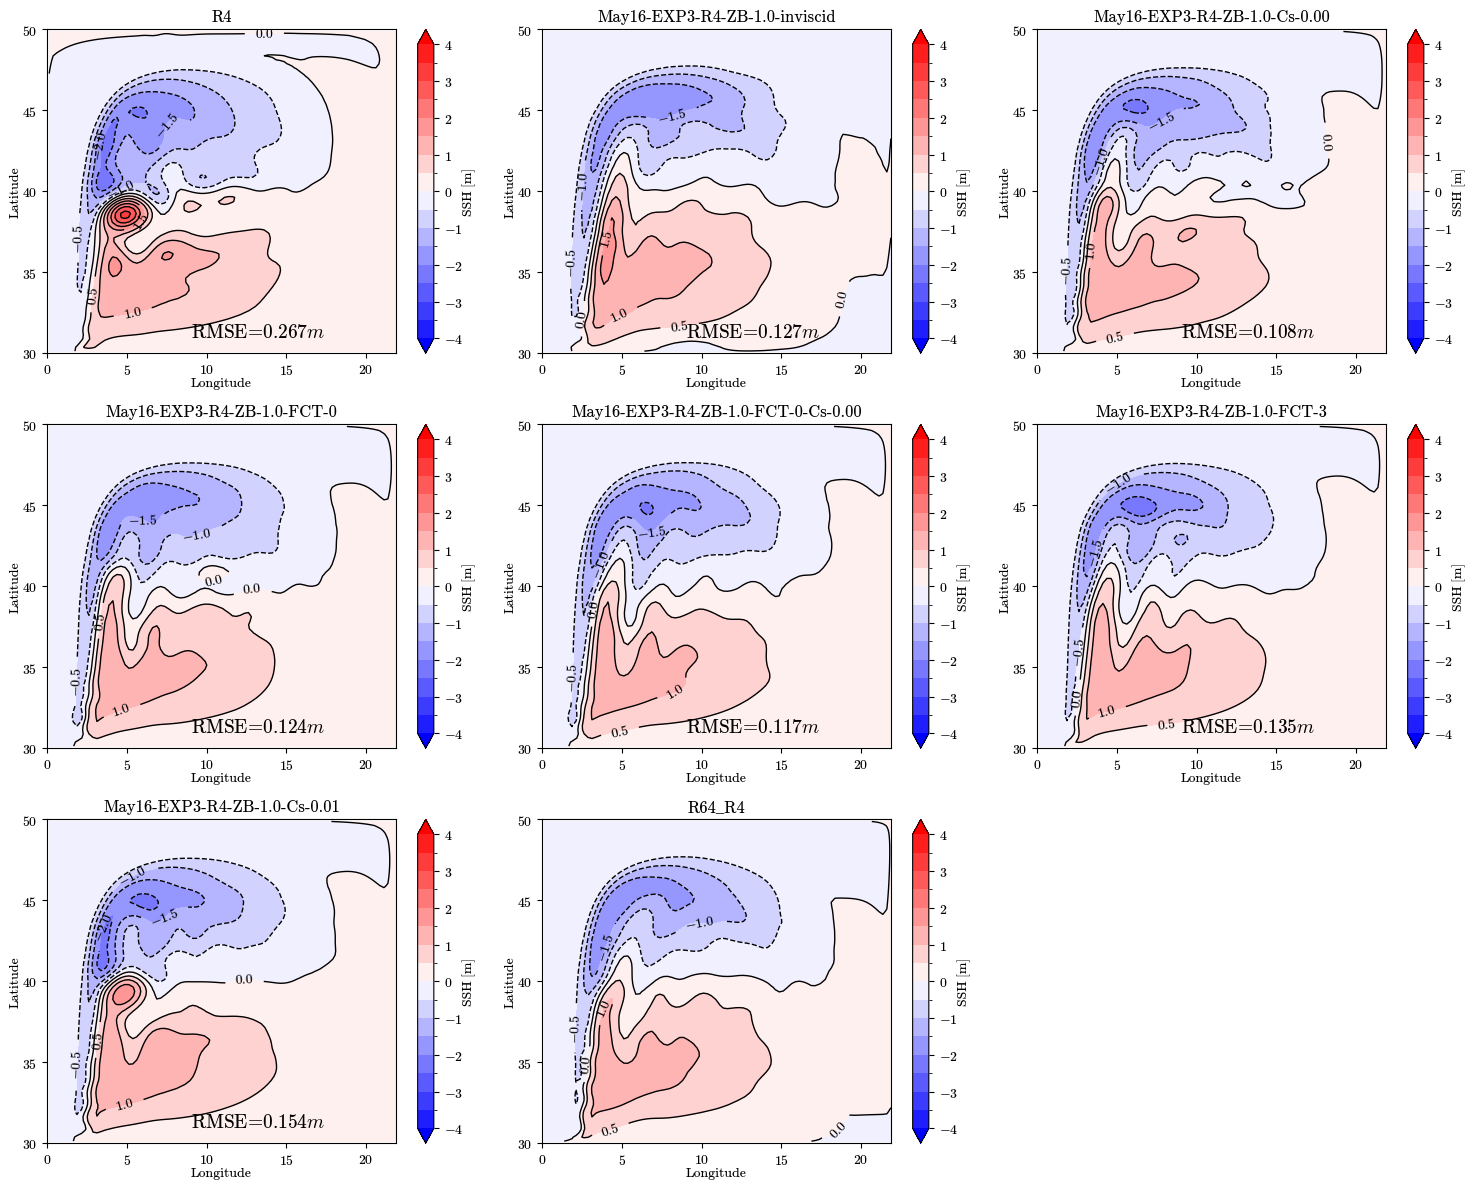

In [51]:
RR = 'R4'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

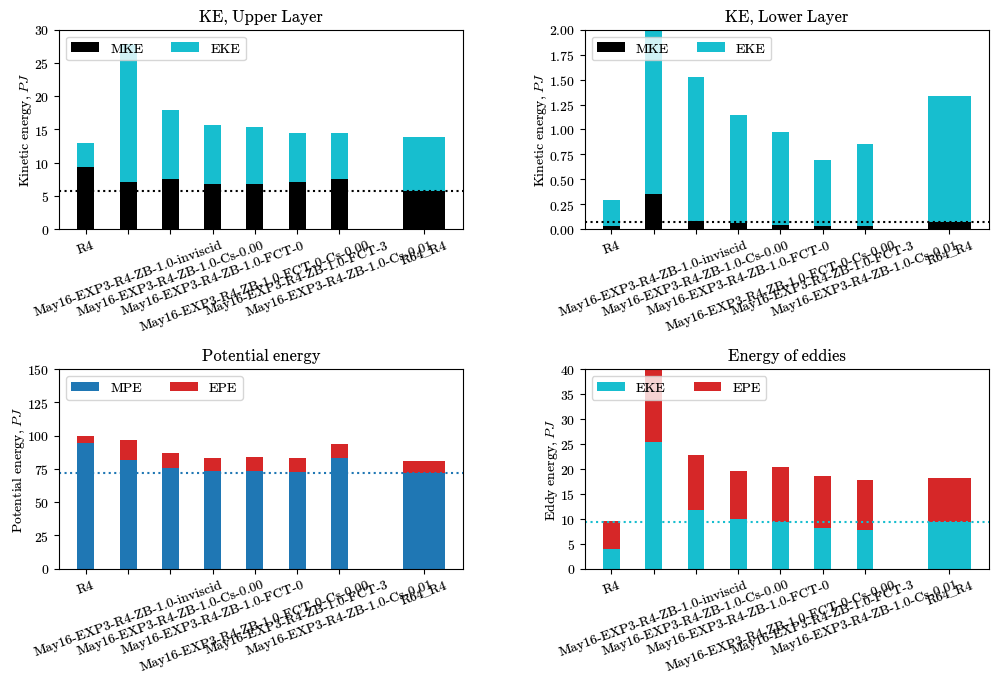

In [52]:
RR = 'R4'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_PE([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

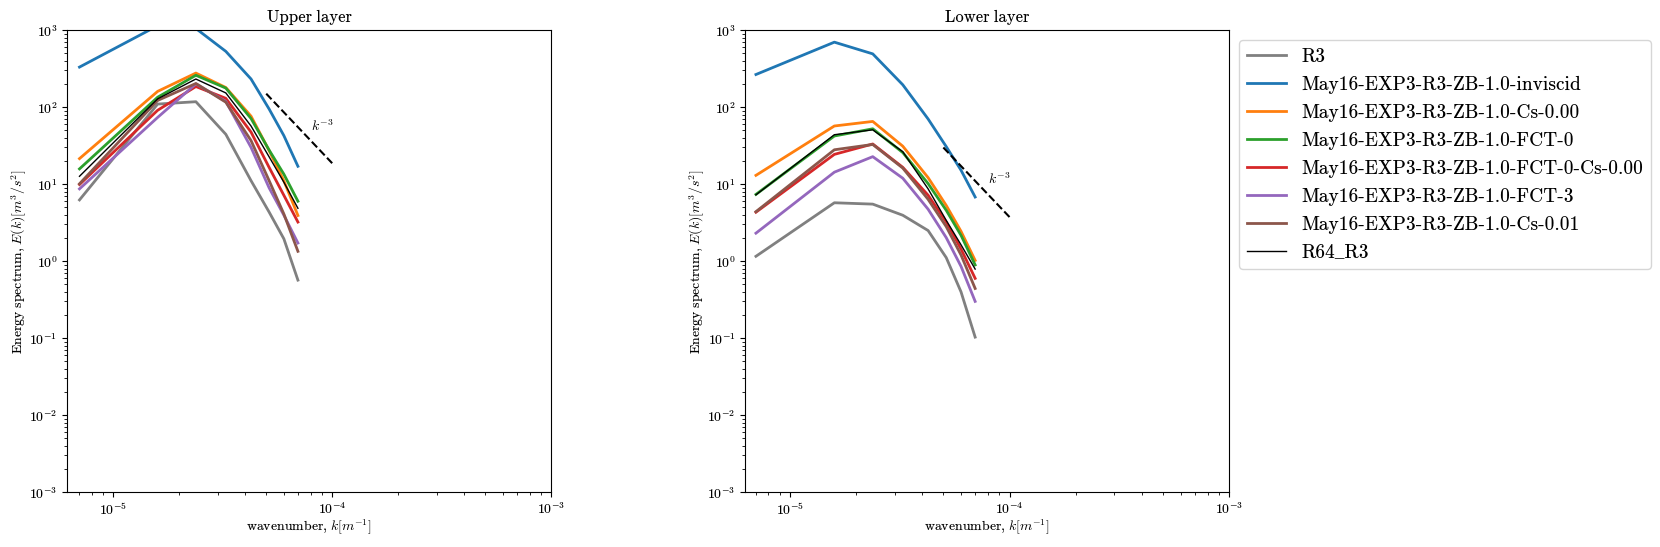

In [53]:
RR = 'R3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_spectrum([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

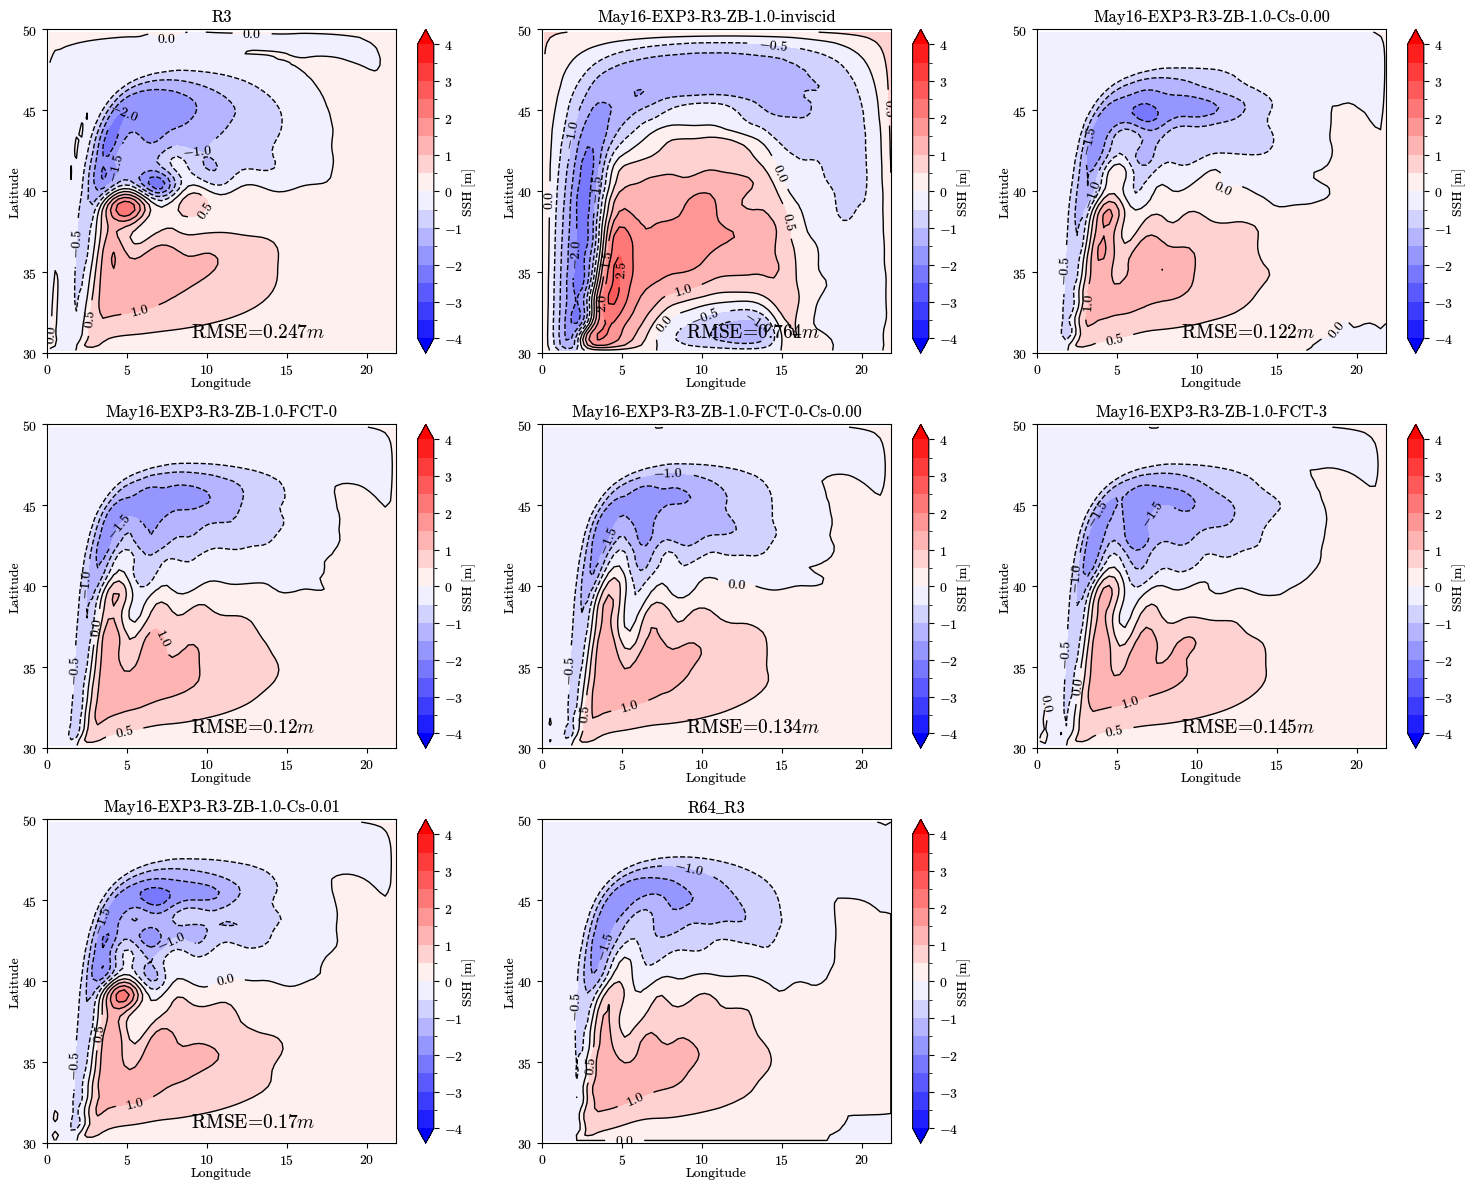

In [54]:
RR = 'R3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

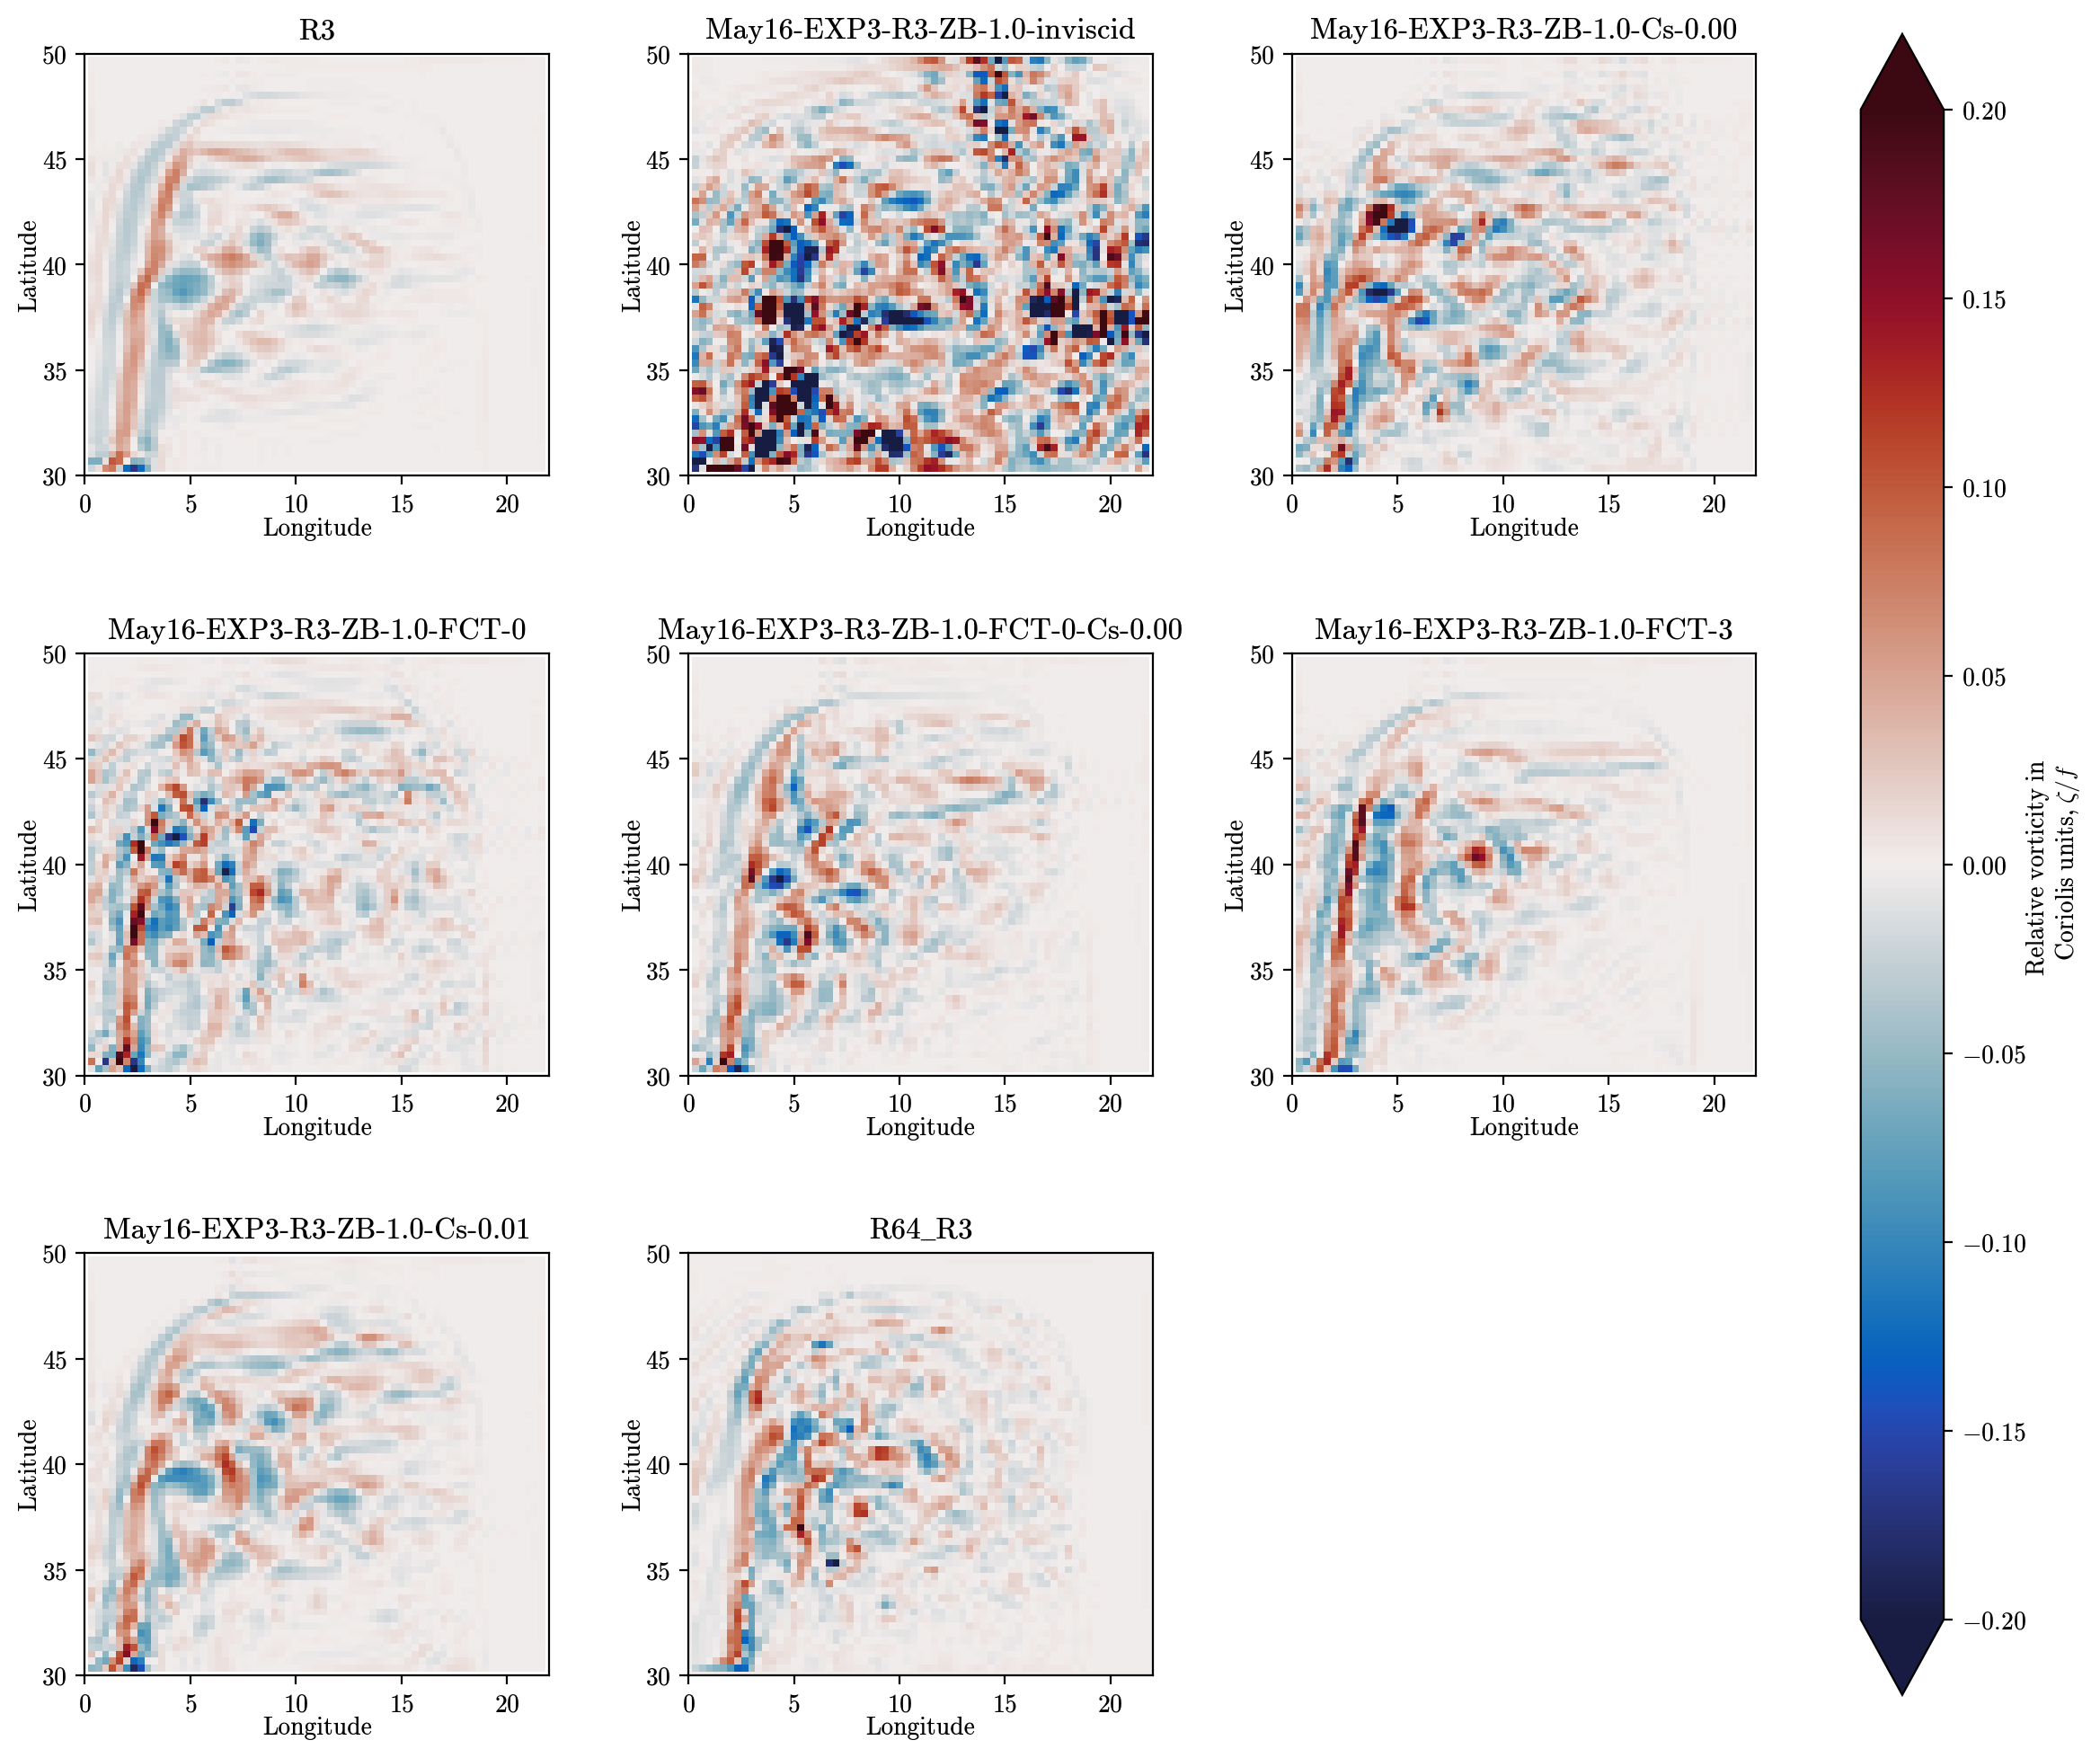

In [55]:
RR = 'R3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_RV([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

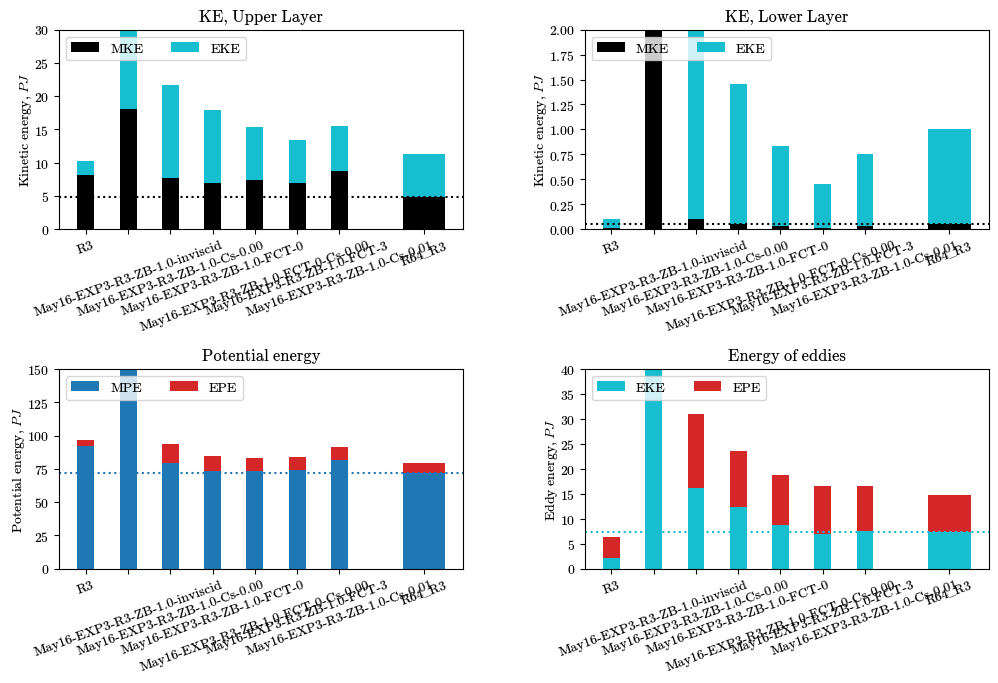

In [56]:
RR = 'R3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_PE([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

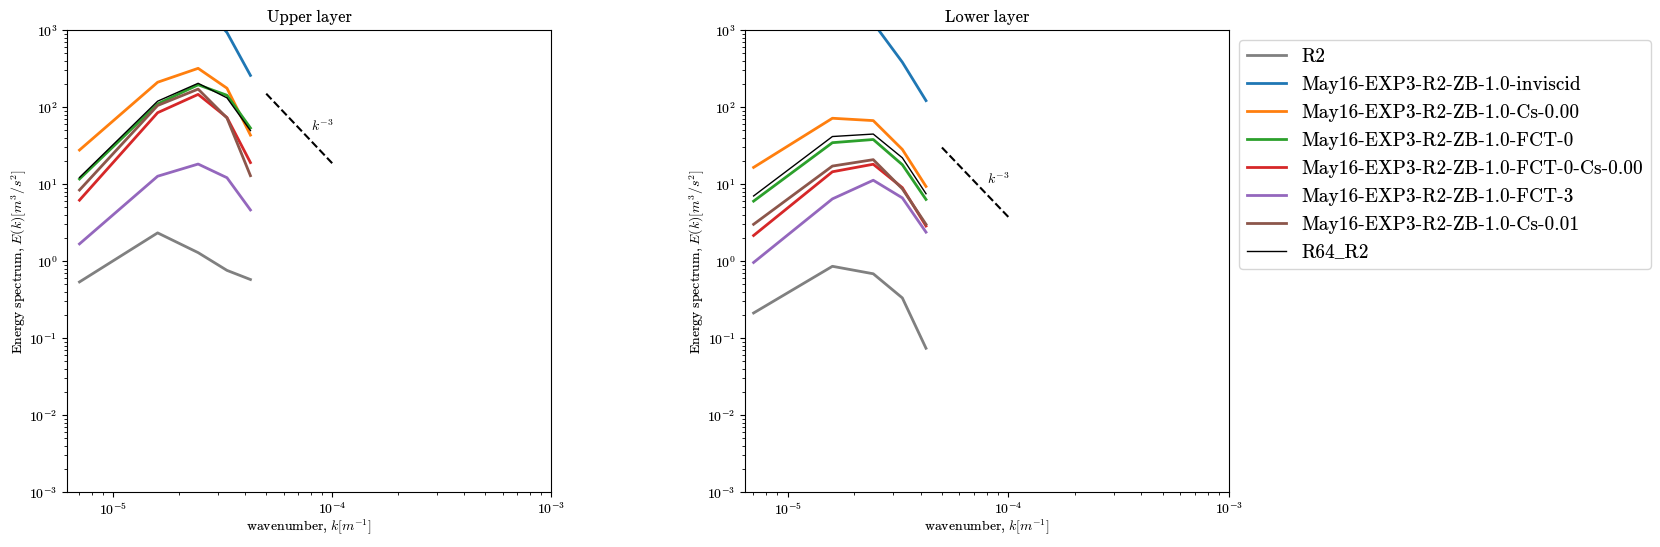

In [57]:
RR = 'R2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_spectrum([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

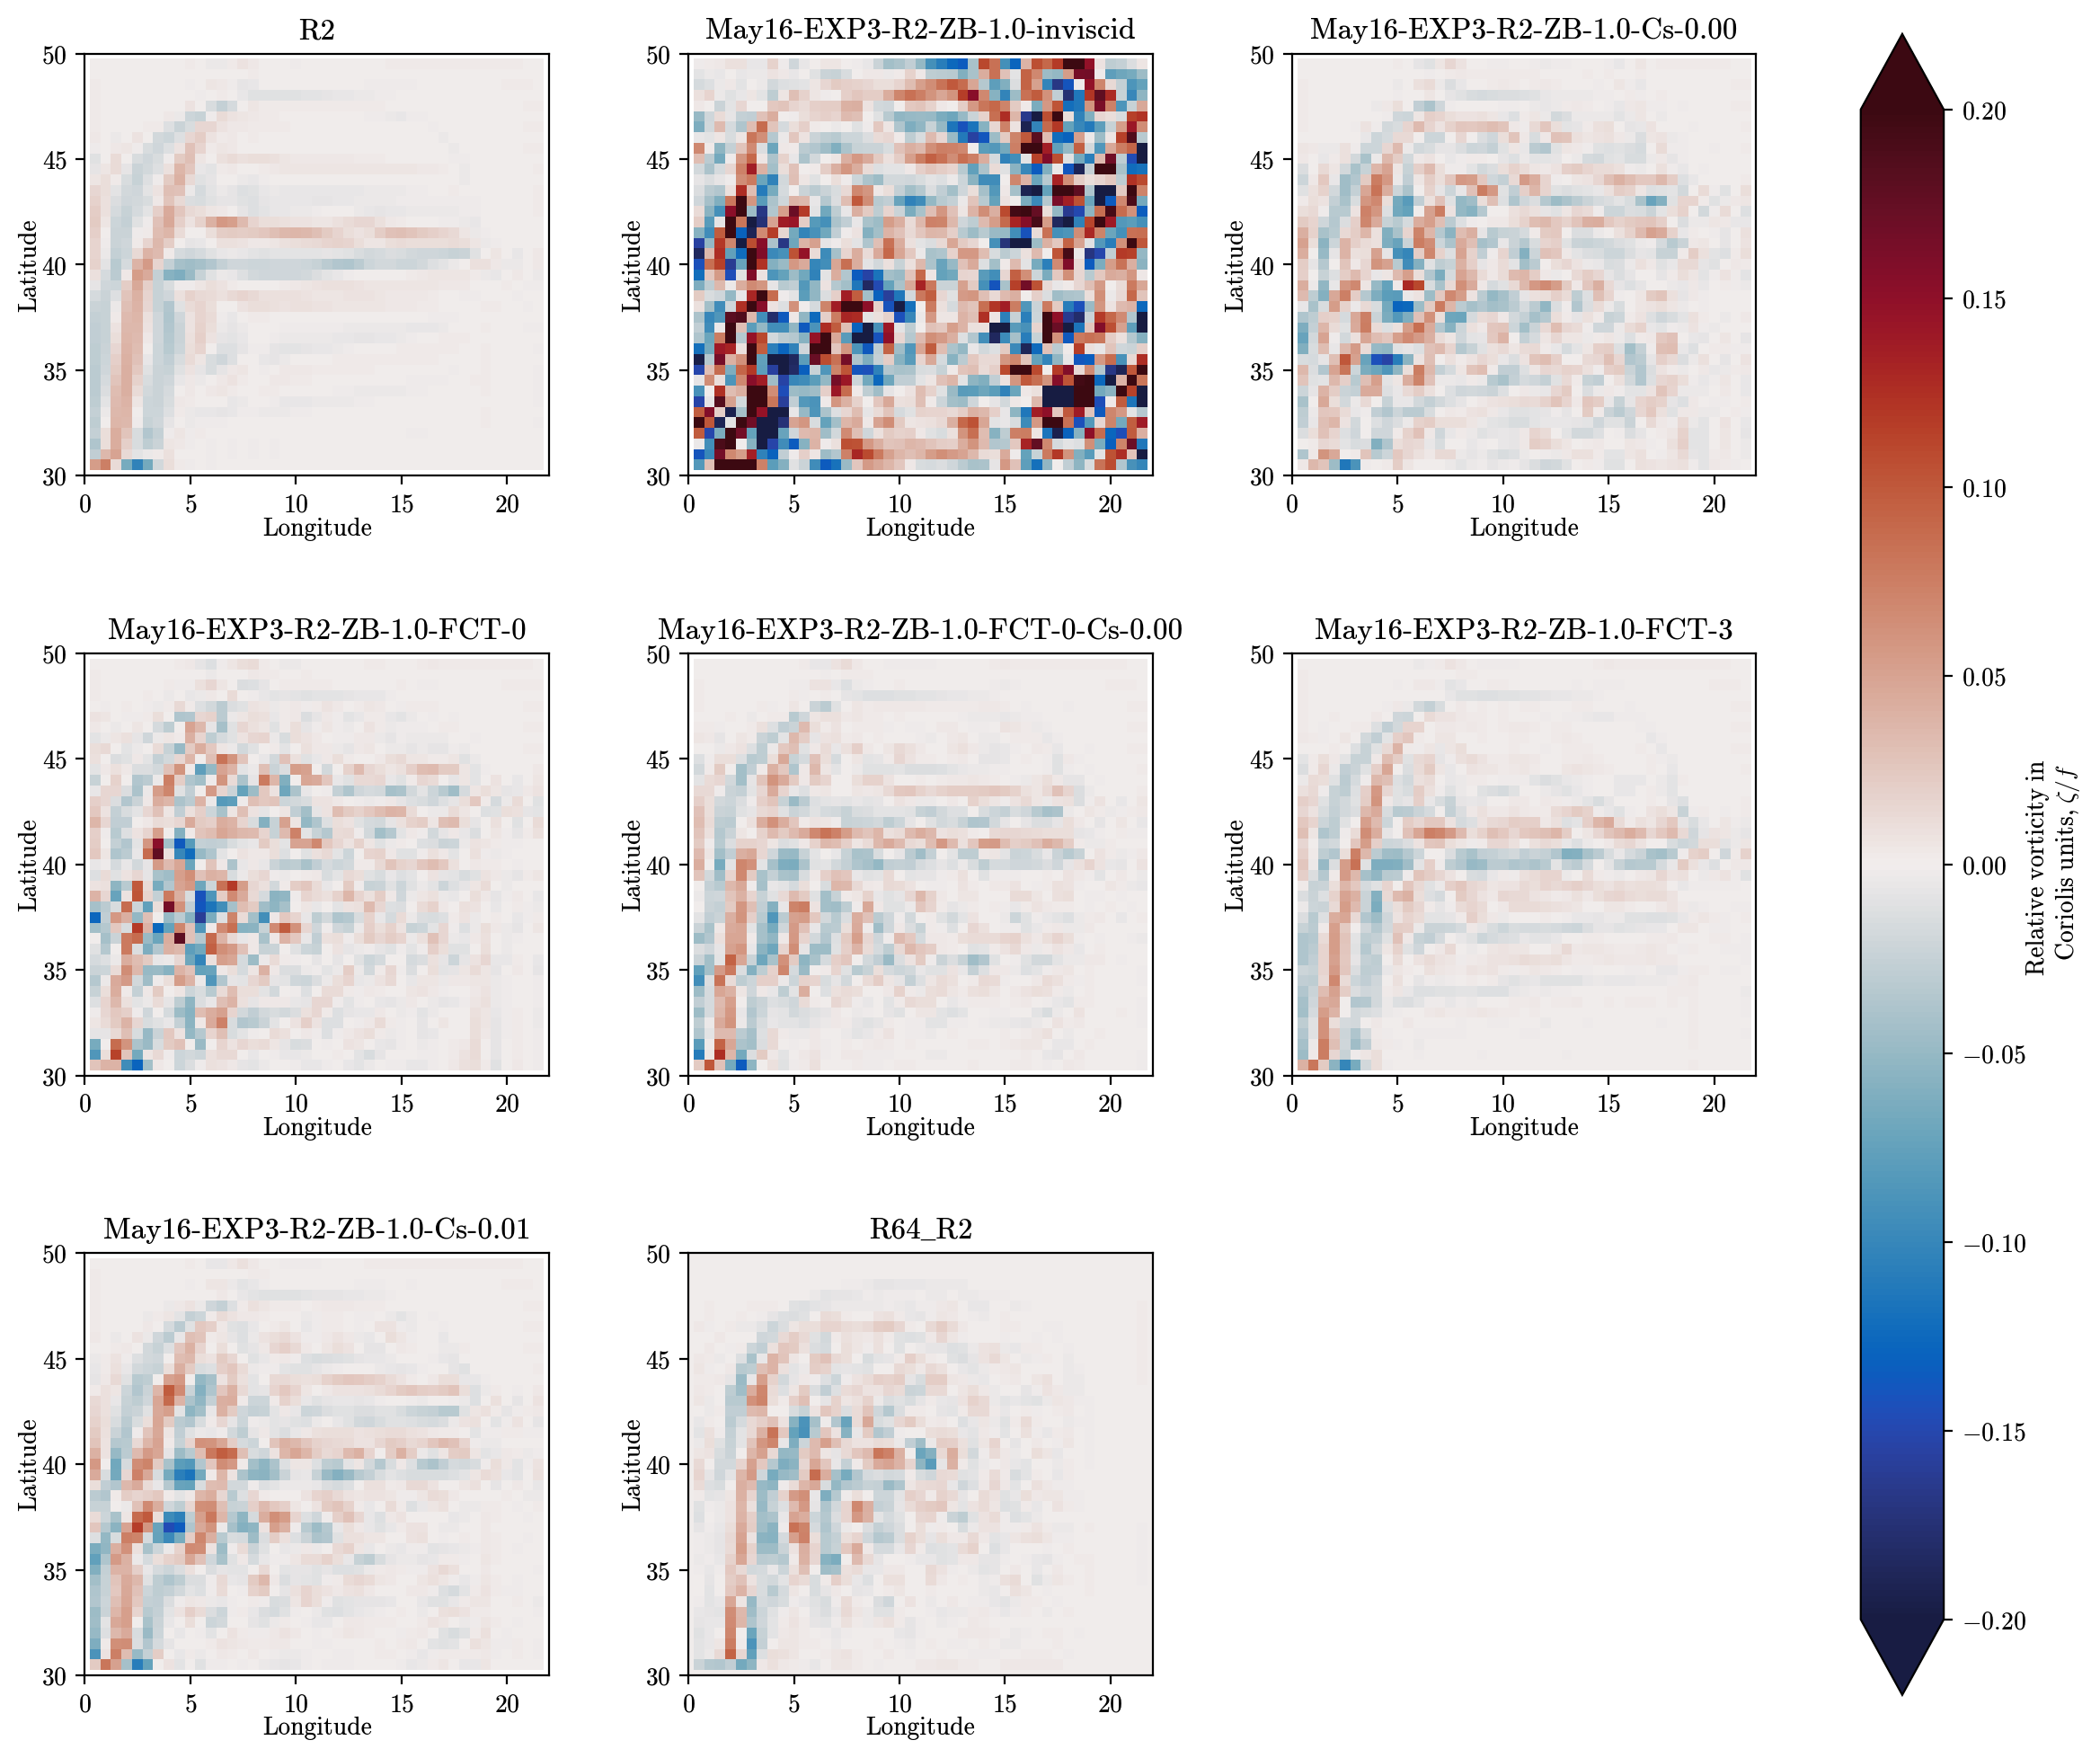

In [58]:
RR = 'R2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_RV([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

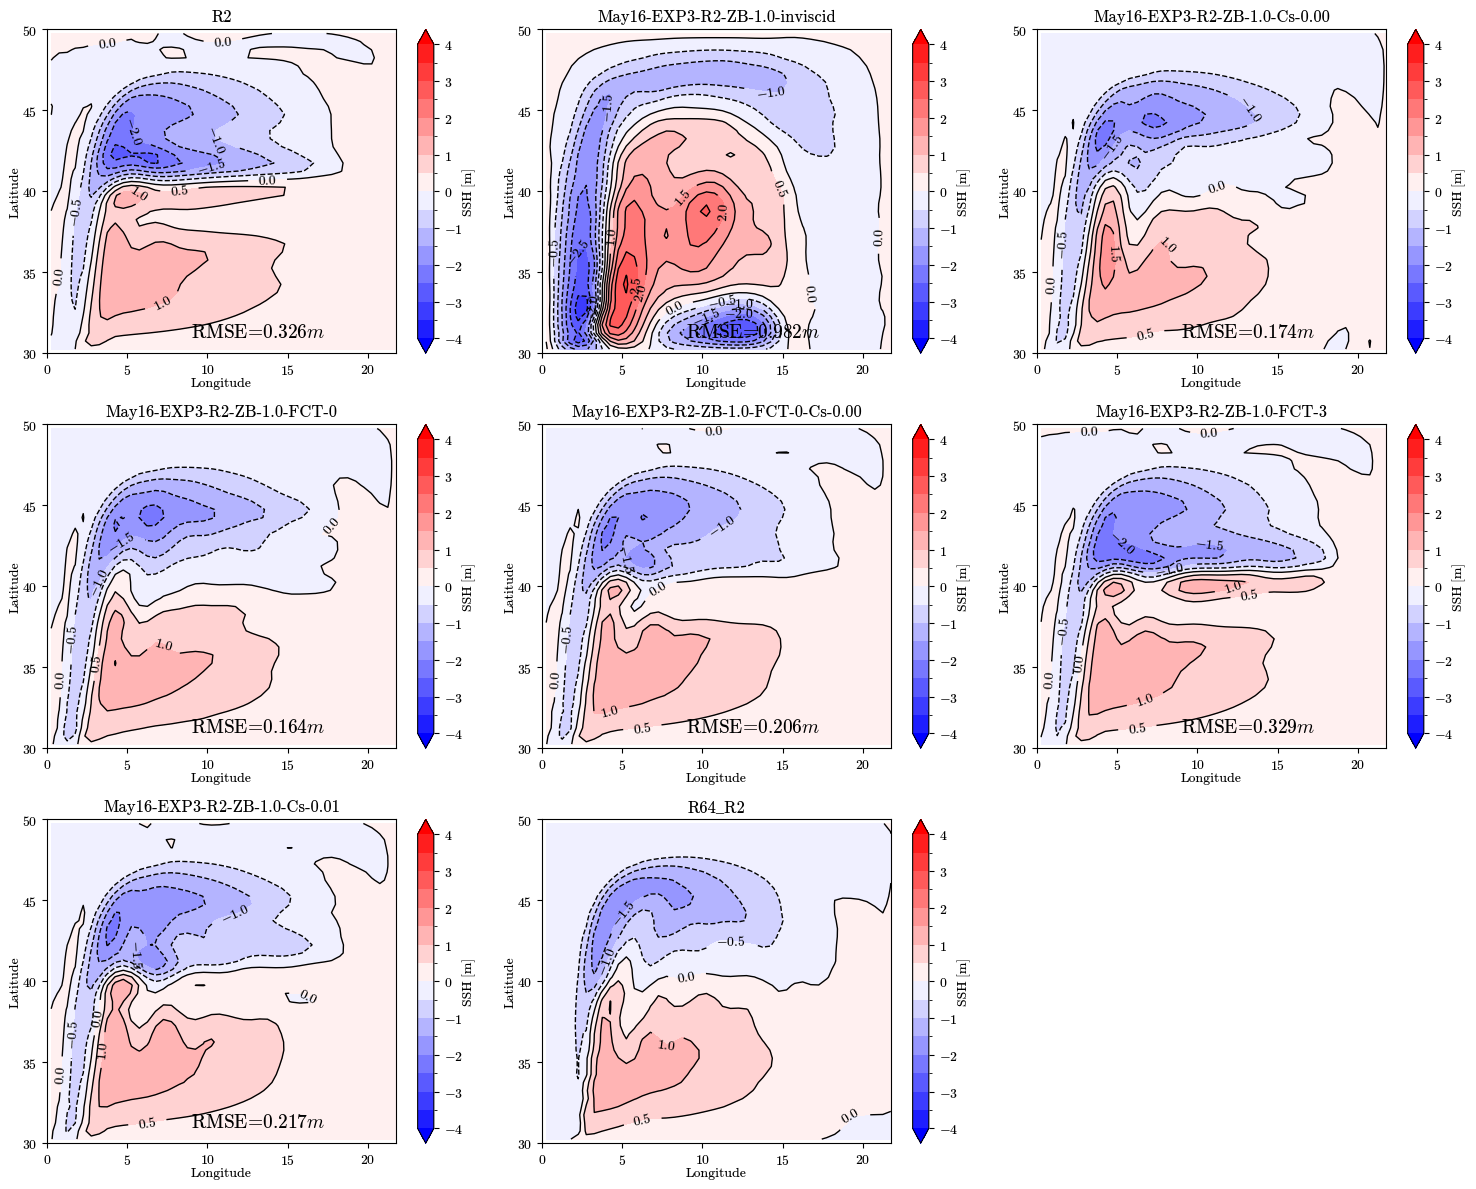

In [59]:
RR = 'R2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

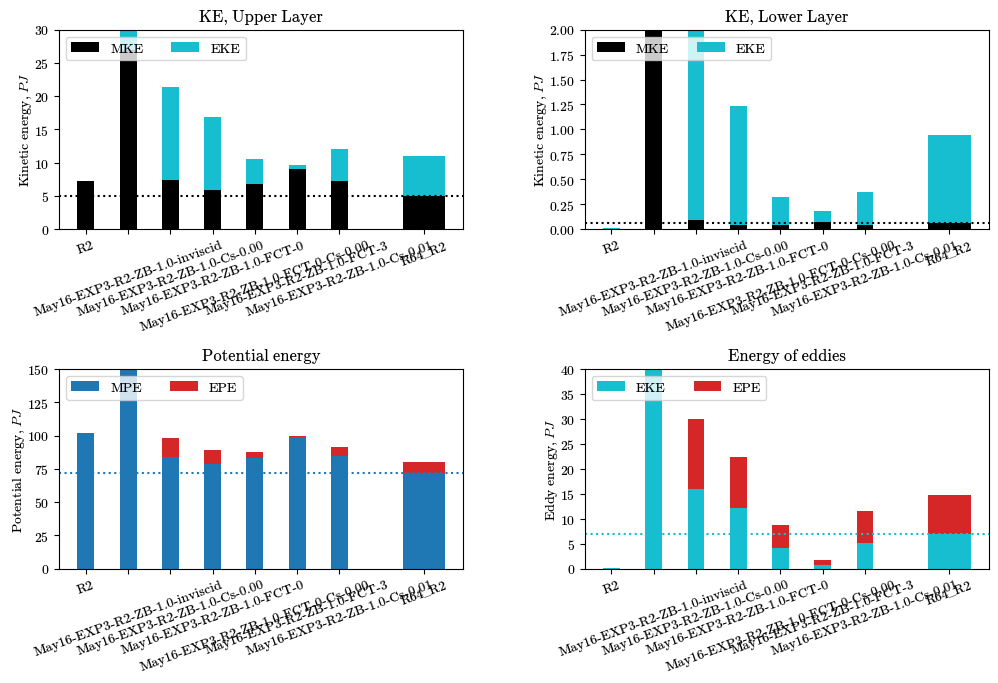

In [60]:
RR = 'R2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_PE([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

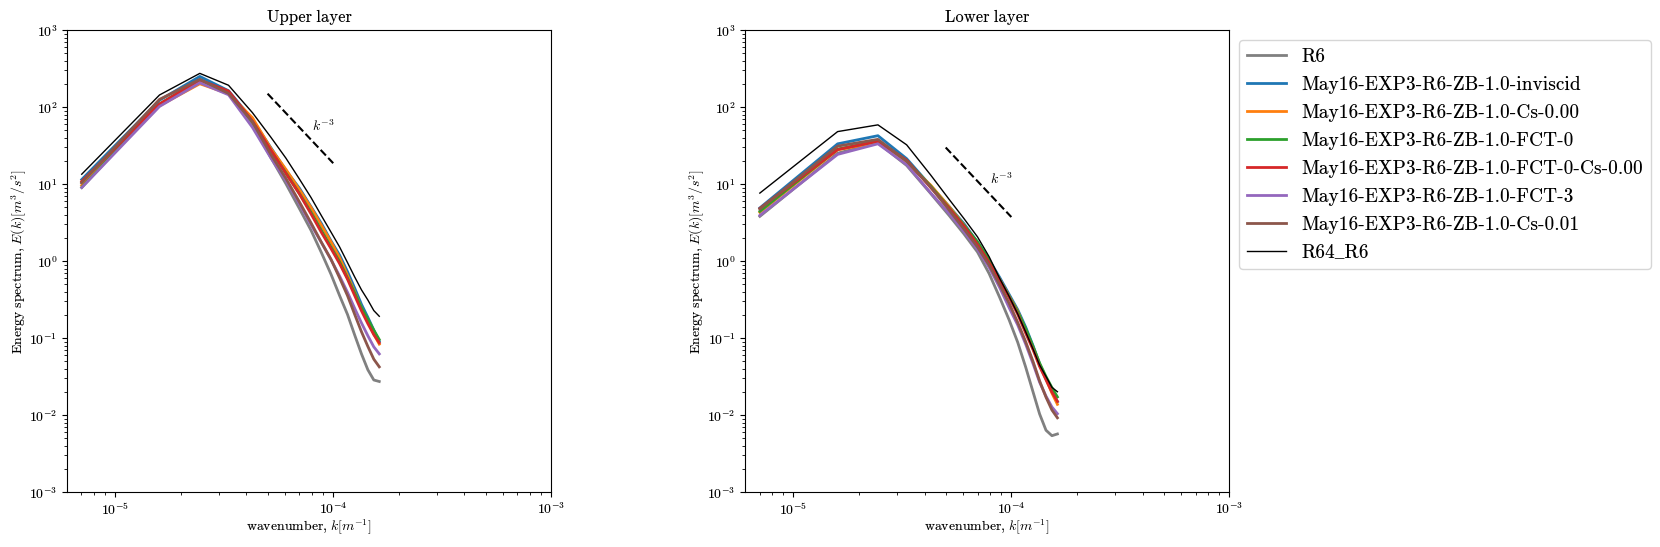

In [61]:
RR = 'R6'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_spectrum([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

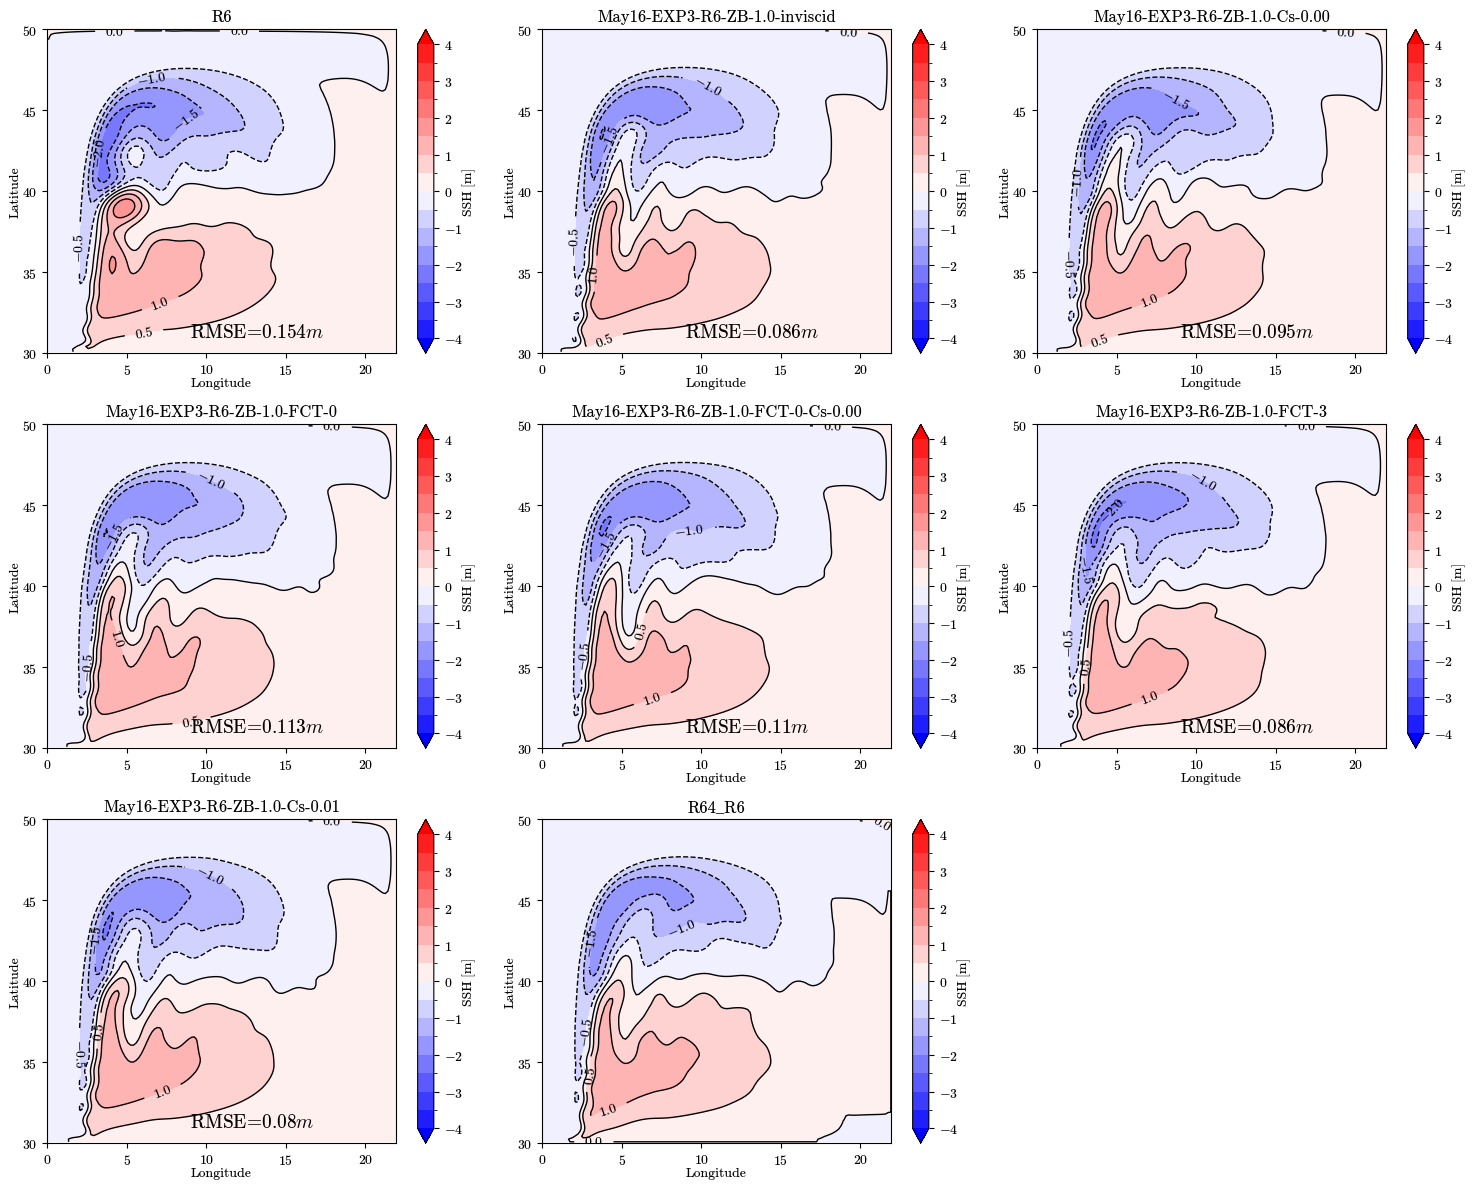

In [62]:
RR = 'R6'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

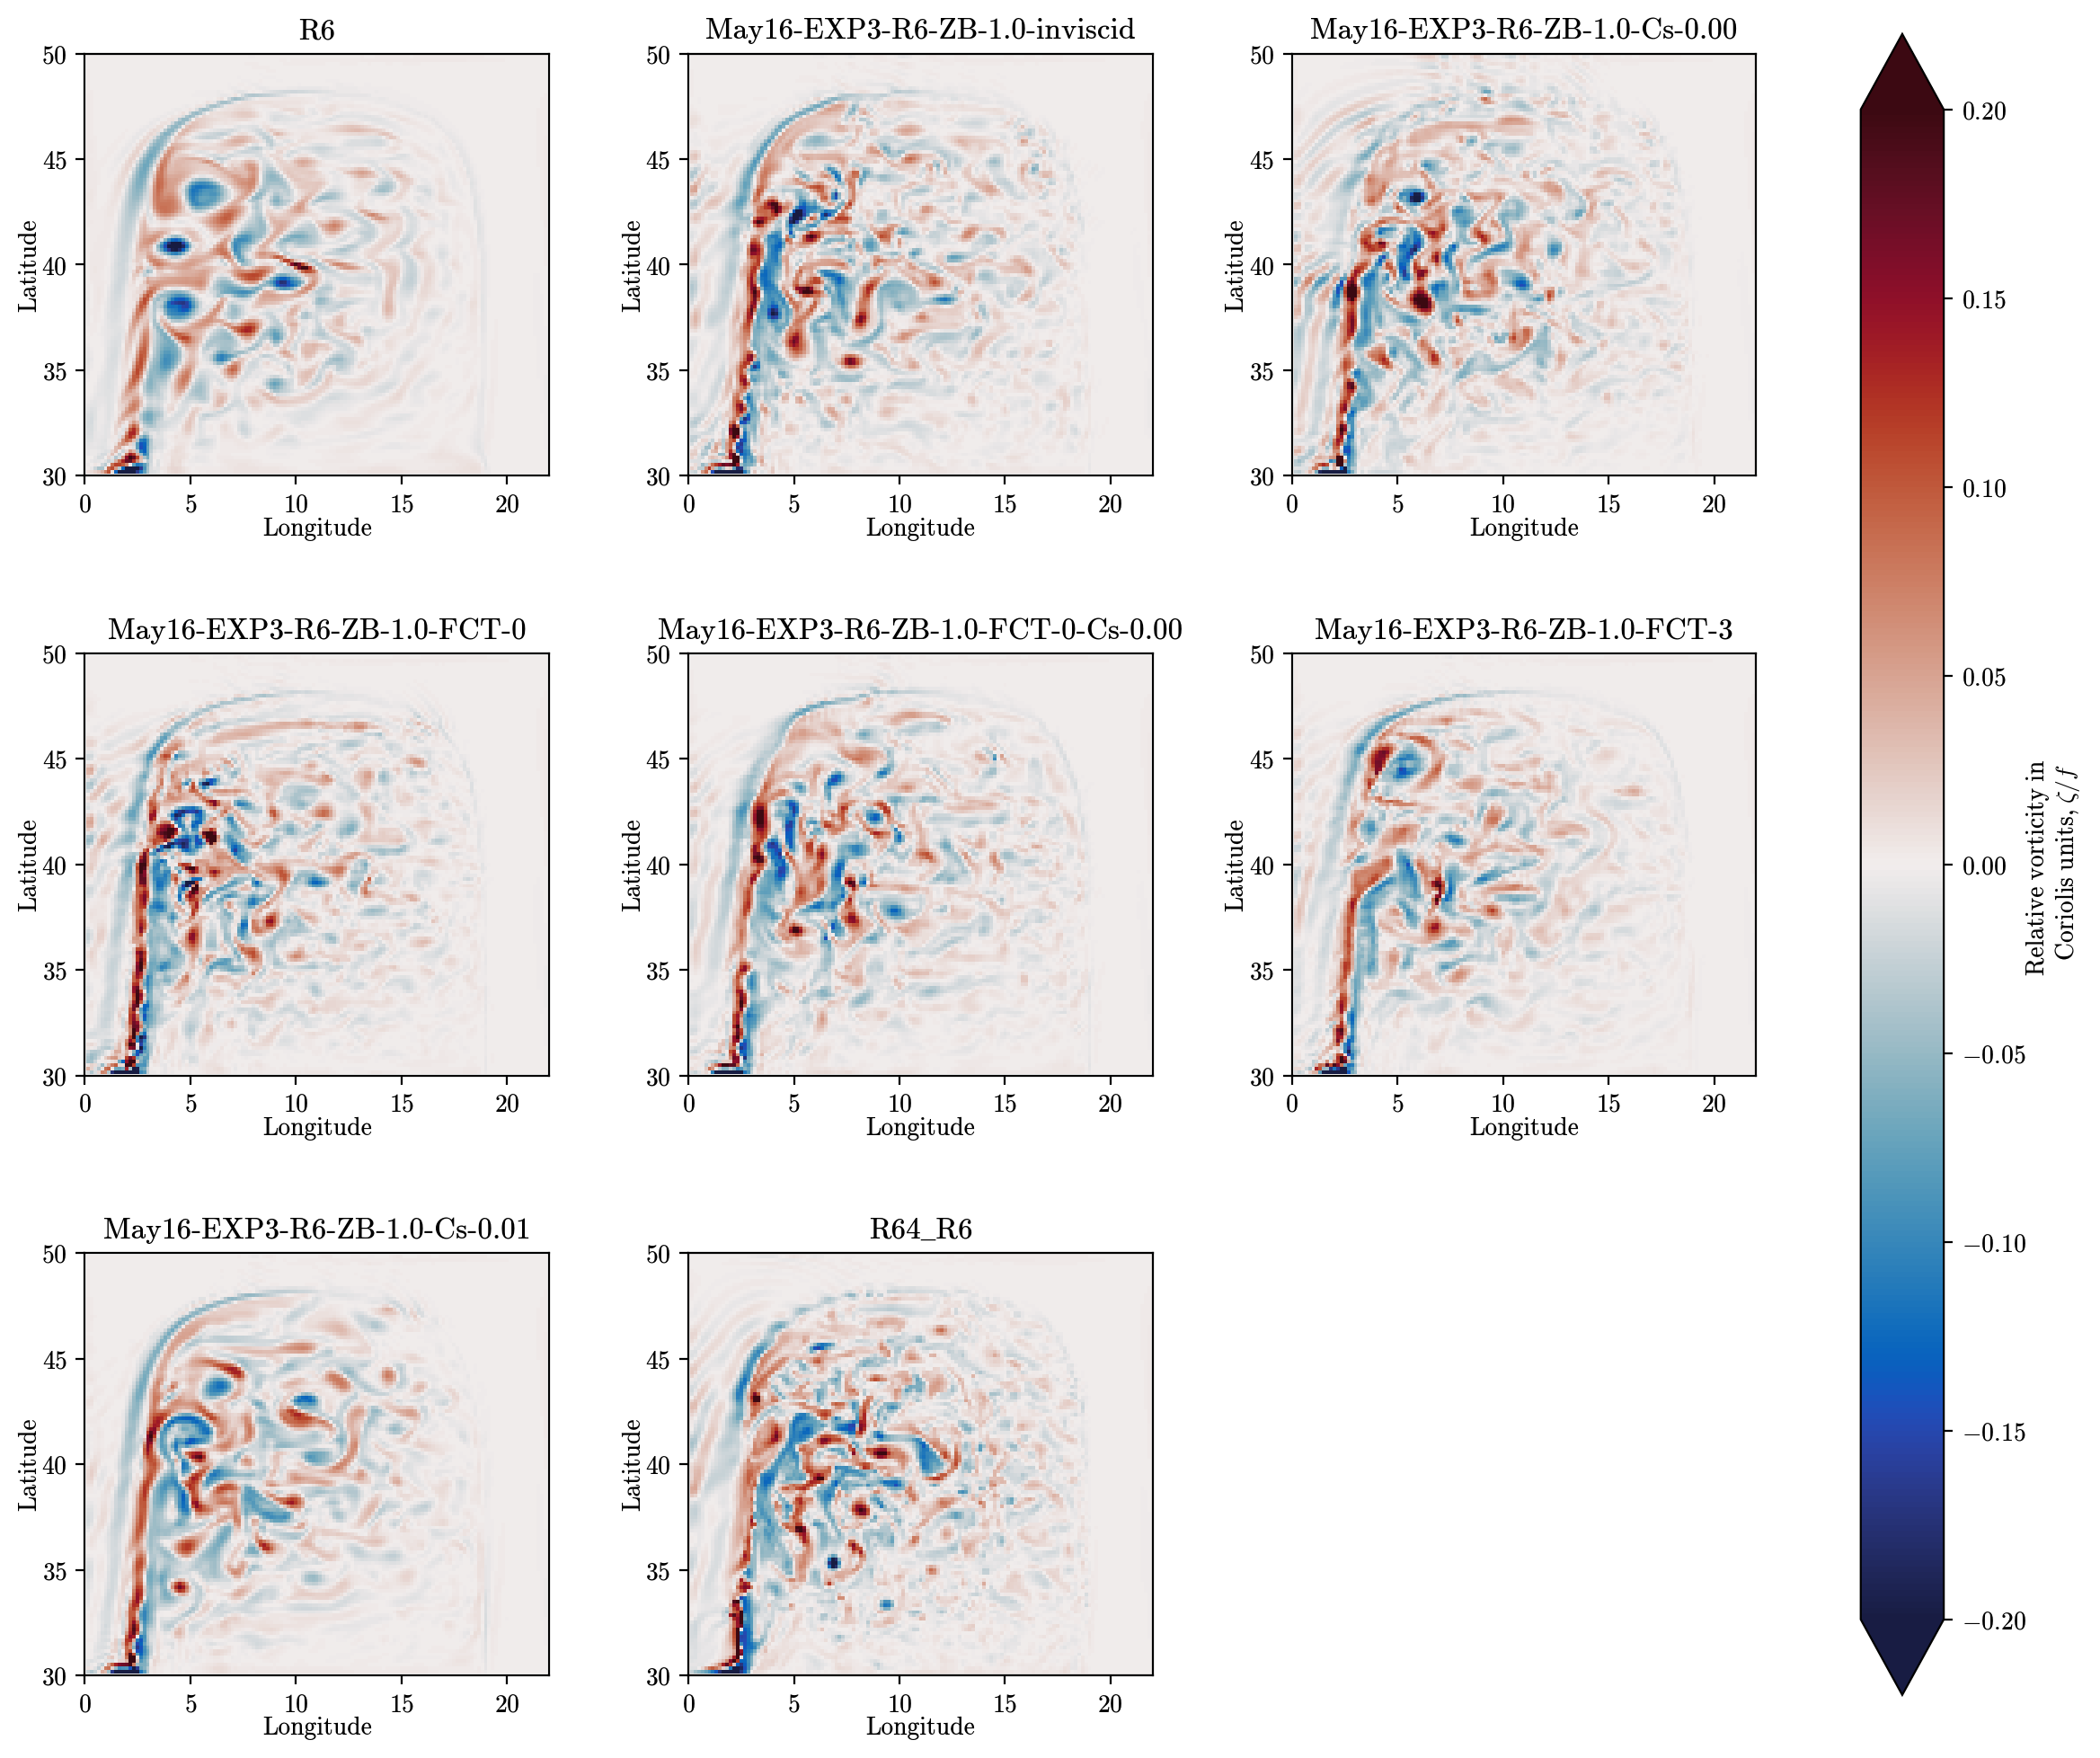

In [63]:
RR = 'R6'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_RV([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

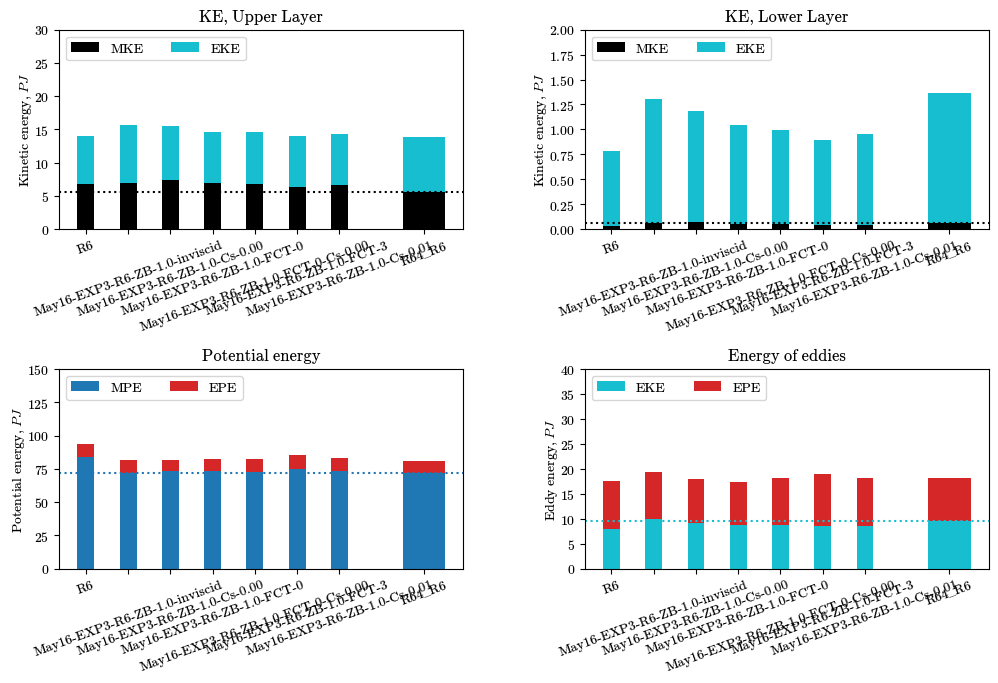

In [64]:
RR = 'R6'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_PE([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

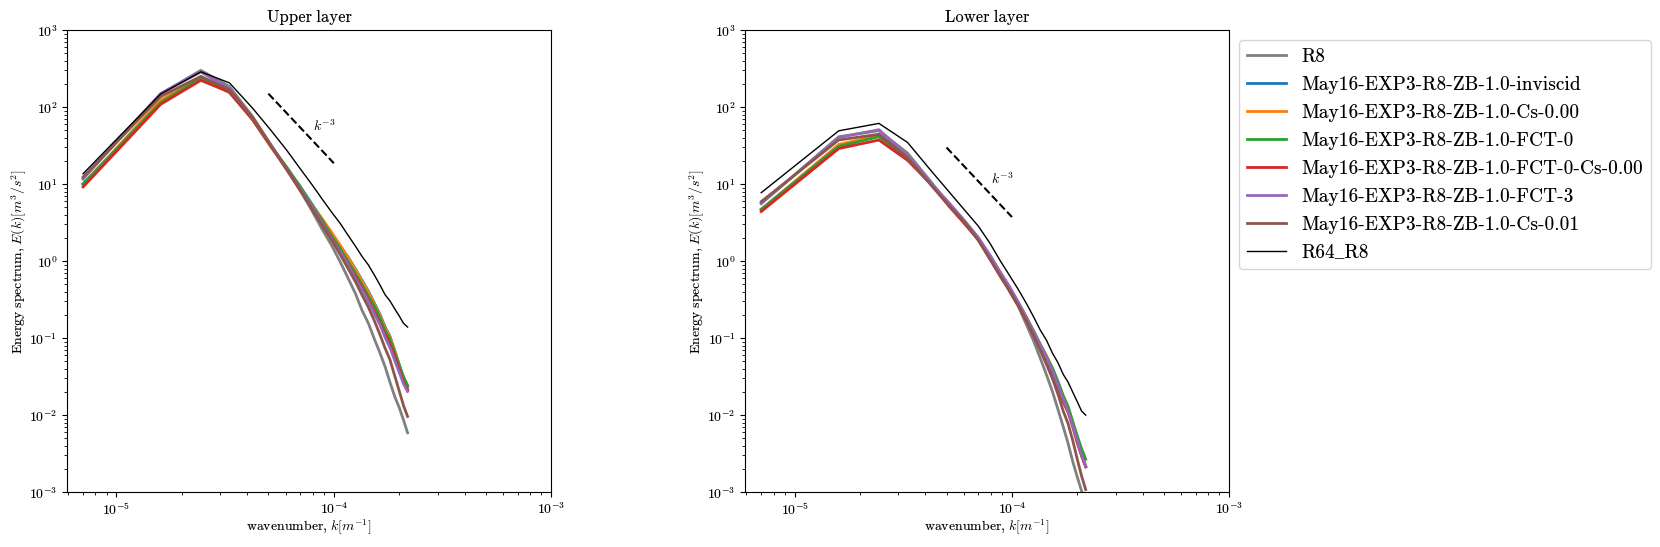

In [65]:
RR = 'R8'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_spectrum([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

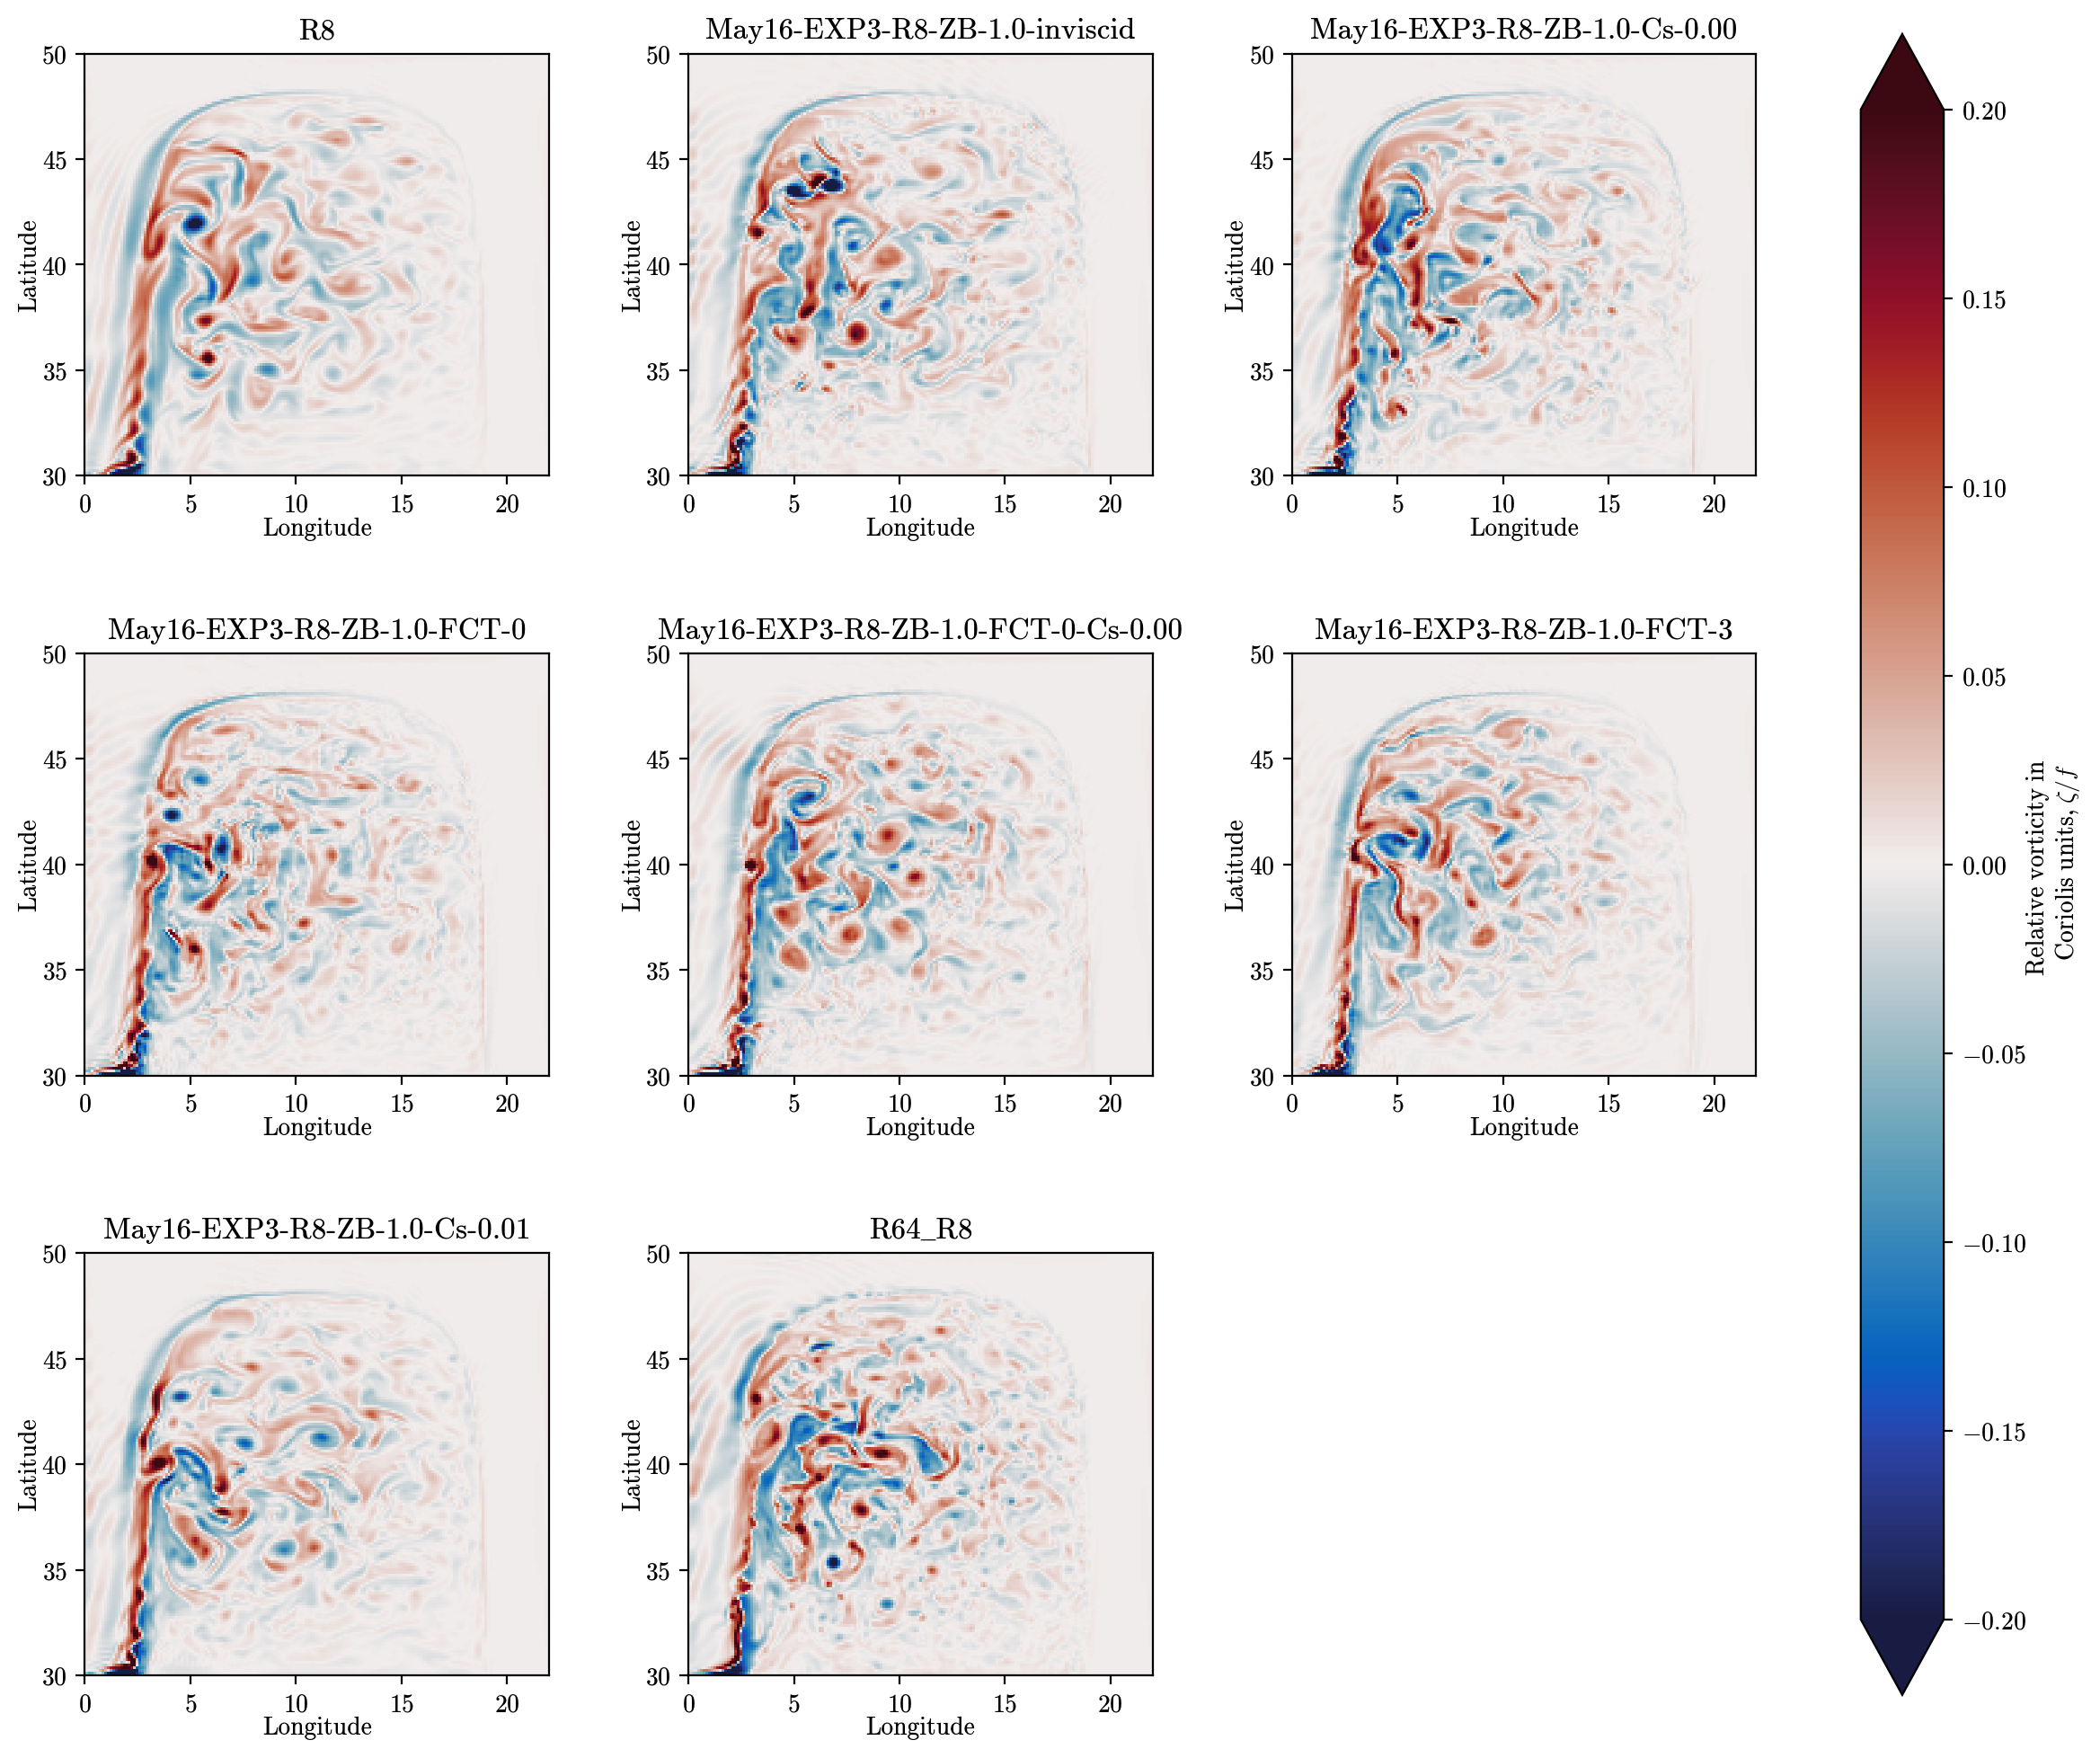

In [66]:
RR = 'R8'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_RV([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

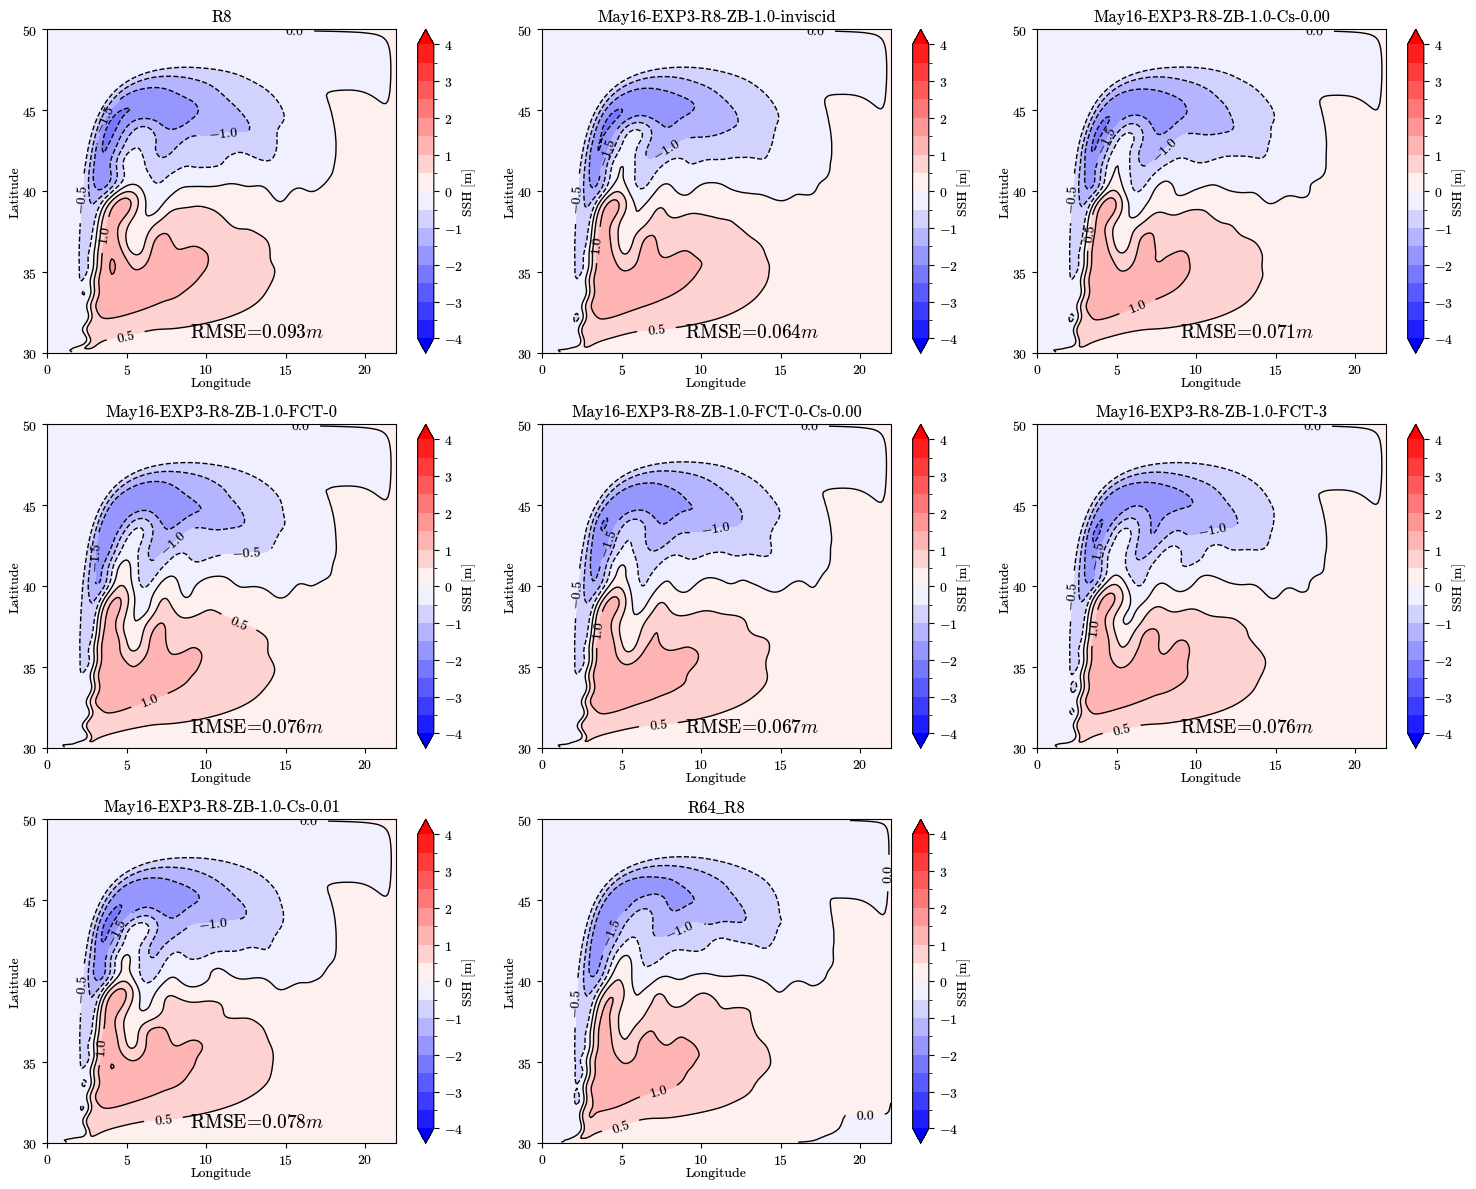

In [67]:
RR = 'R8'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

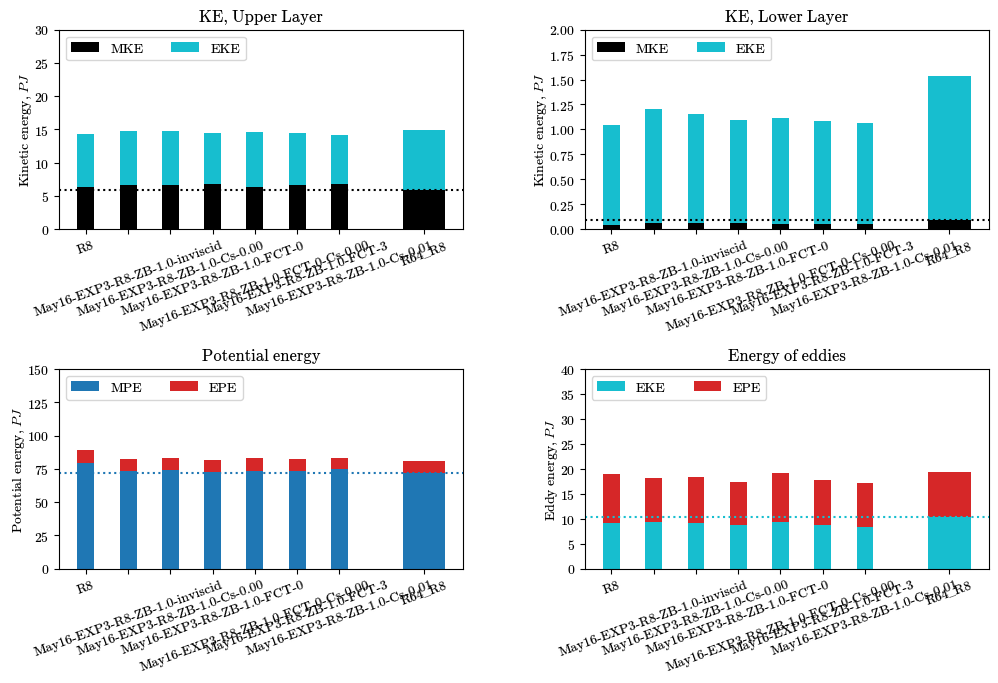

In [68]:
RR = 'R8'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_KE_PE([RR, 
                     f'May16-EXP3-{RR}-ZB-1.0-inviscid', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-0', f'May16-EXP3-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-EXP3-{RR}-ZB-1.0-FCT-3', f'May16-EXP3-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

# Summary
* FCT-3 limiter does not seems to be well numerically formulated: it generates noise when downgradient model is zero
* FCT-0 limiter is better. Without any downgradient model, the solution is smooth.
* Inviscid ANN seems to do not provide backscatter at high resolution, and abruptly change to very strong backscatter around $1/5^o$
* An ideal limiter/viscosity regularization for such ANN is nothing for high resolution and something for coarser resolution.
* Second realization of ANN shows better SSH prediction for most of regularization methods at high resolution. We would assume that it is the best asymptotic model.
* The most mild limiting at coarse resolutions is provided by FCT-0. However, the solution is a bit too energetic. To determine if this variability is correct, we compare additional metrics below.

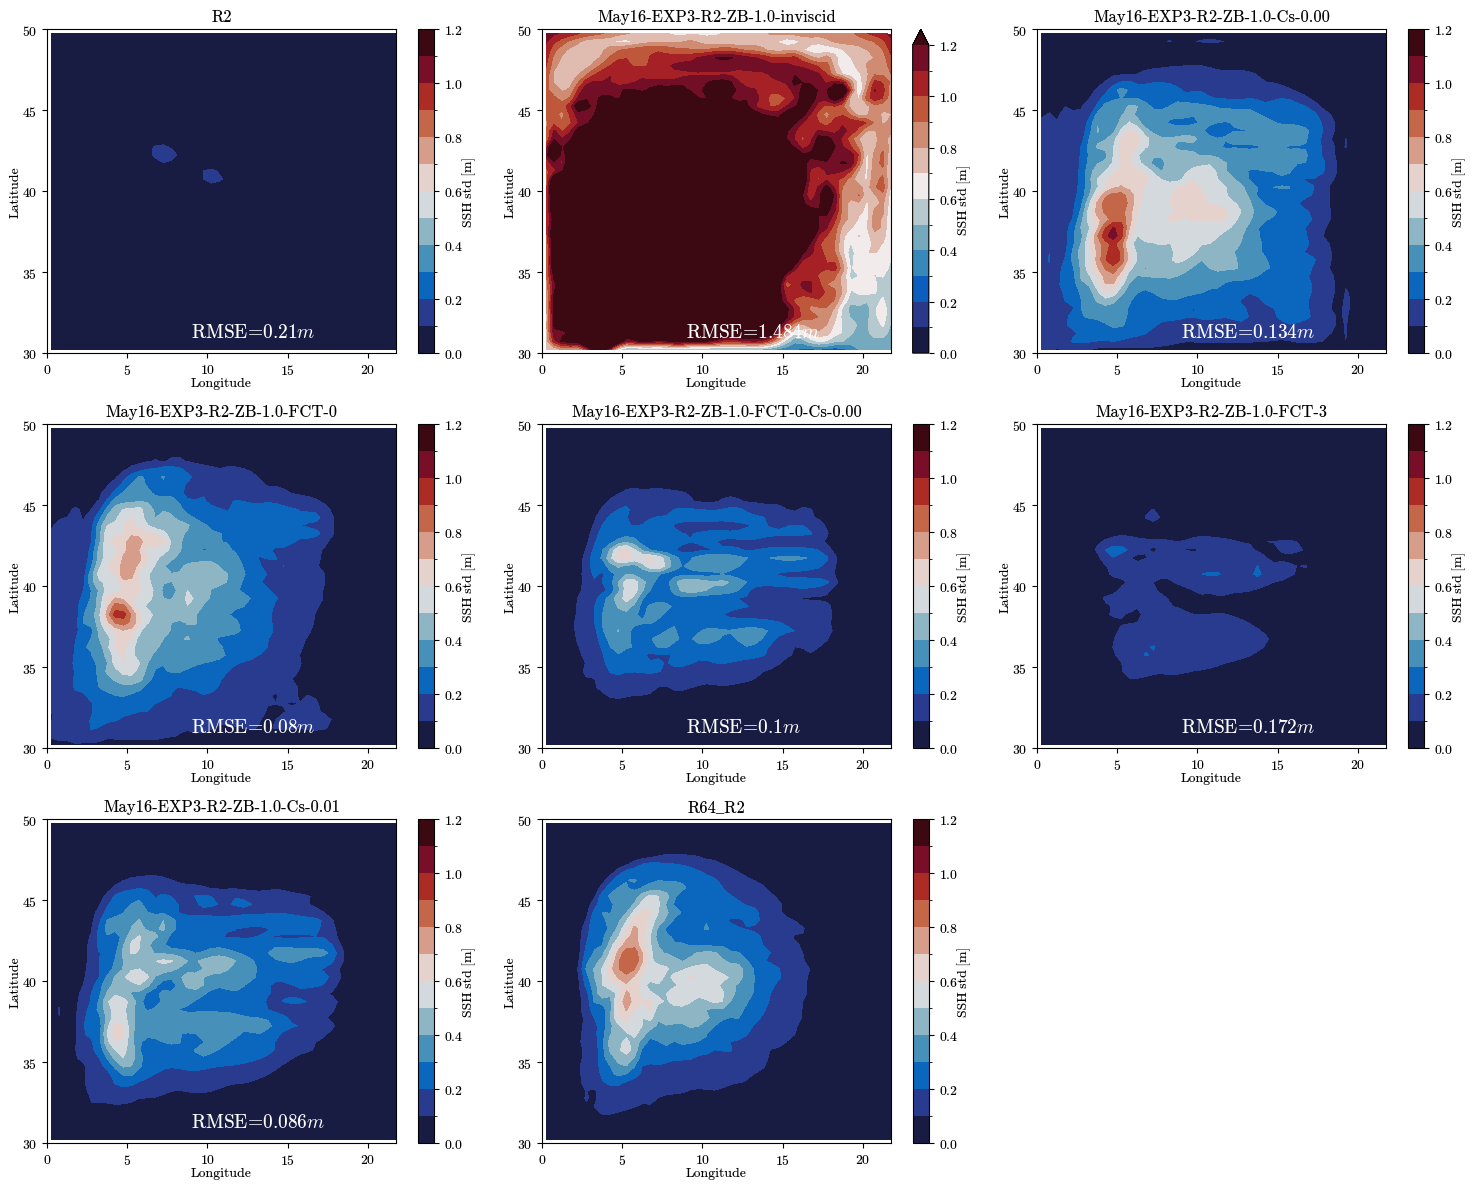

In [70]:
RR = 'R2'
exp = 'EXP3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh_std([RR, 
                     f'May16-{exp}-{RR}-ZB-1.0-inviscid', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

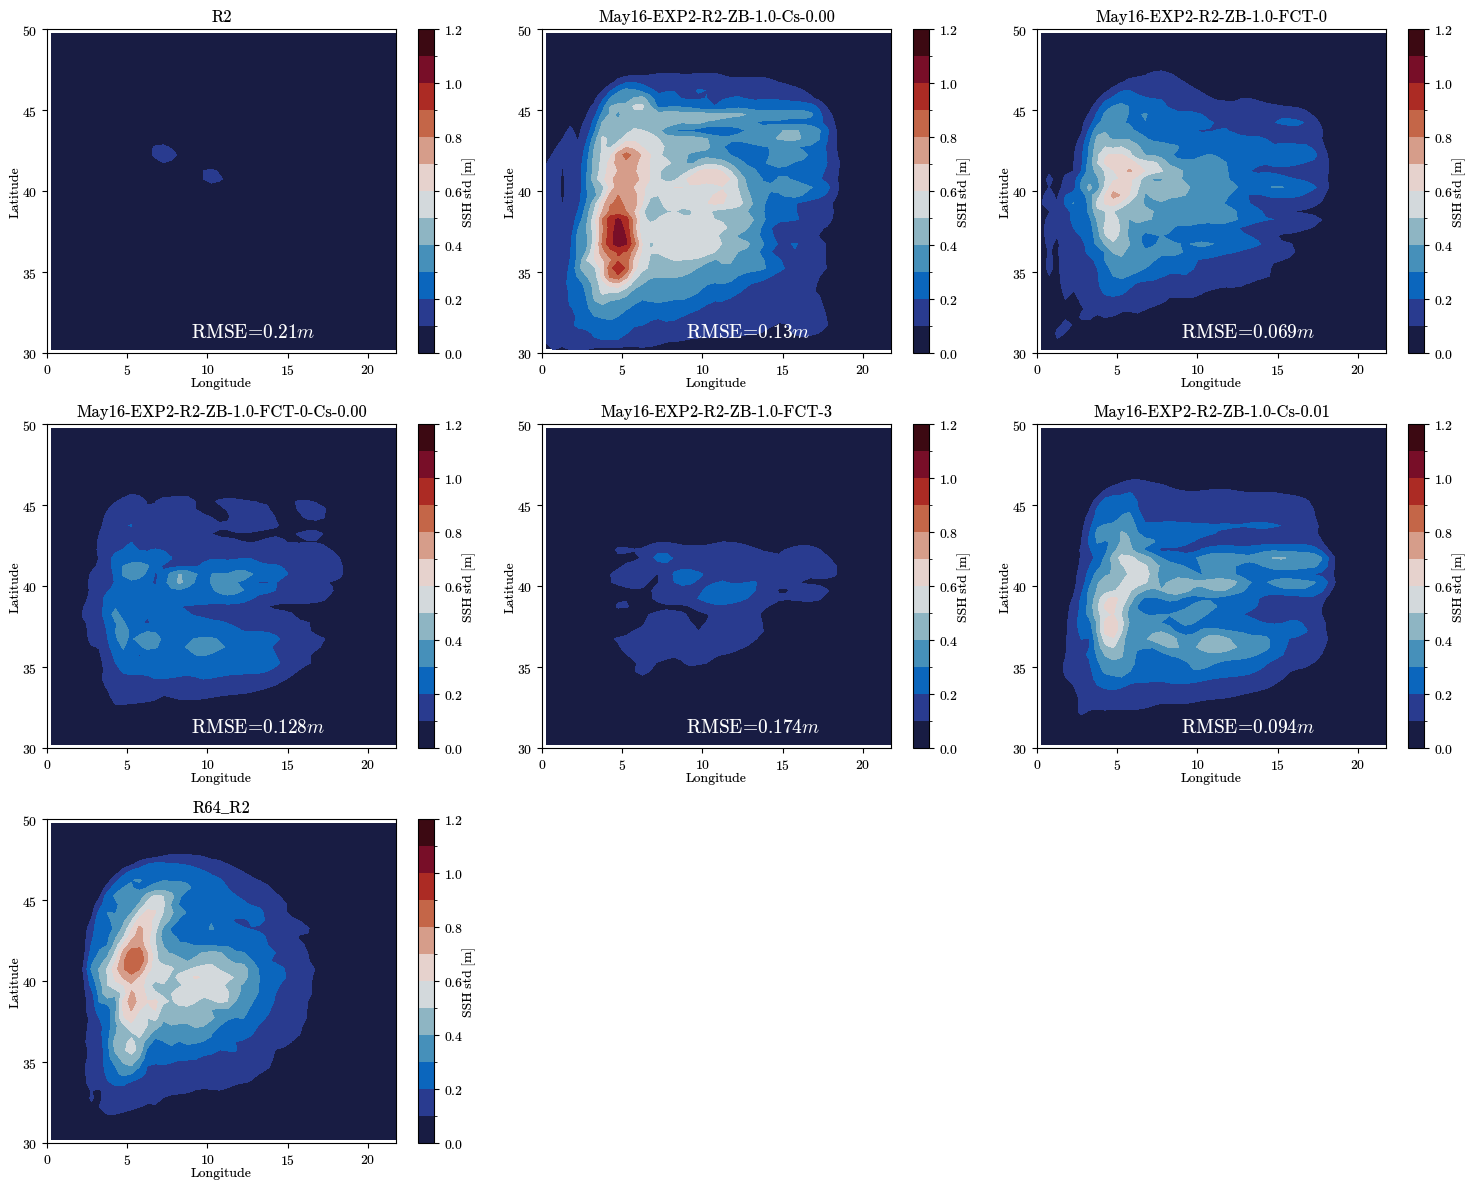

In [72]:
RR = 'R2'
exp = 'EXP2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh_std([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

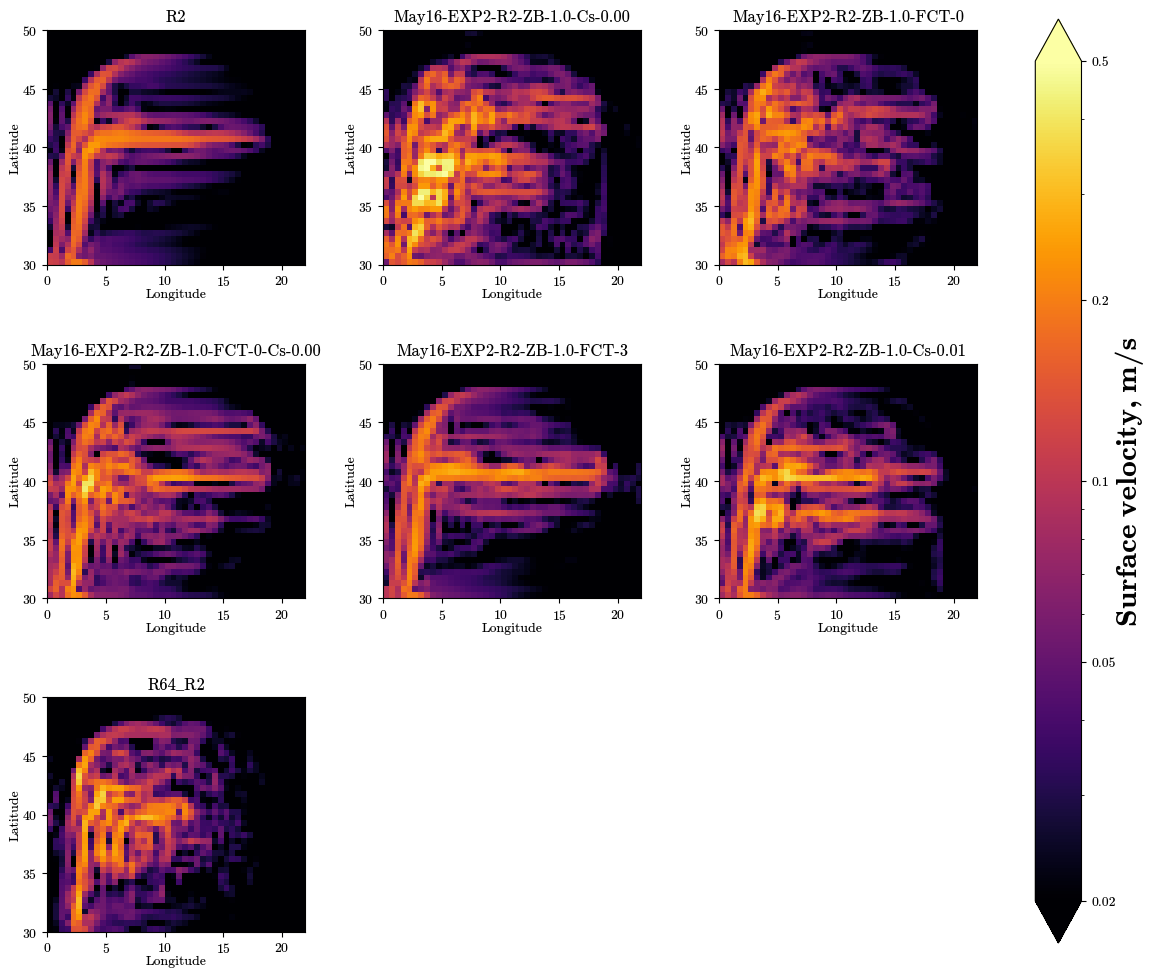

In [73]:
RR = 'R2'
exp = 'EXP2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_velocity_snapshot([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

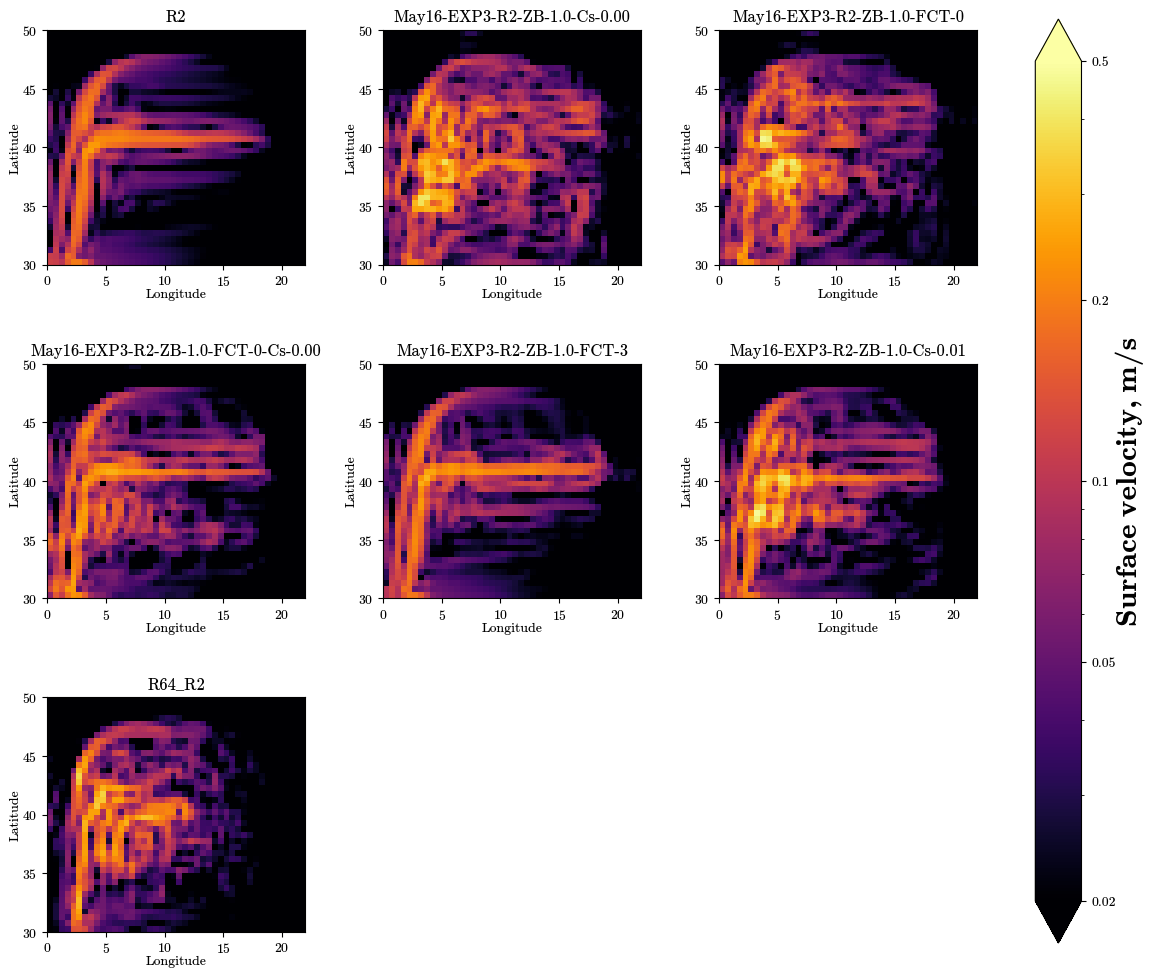

In [74]:
RR = 'R2'
exp = 'EXP3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_velocity_snapshot([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

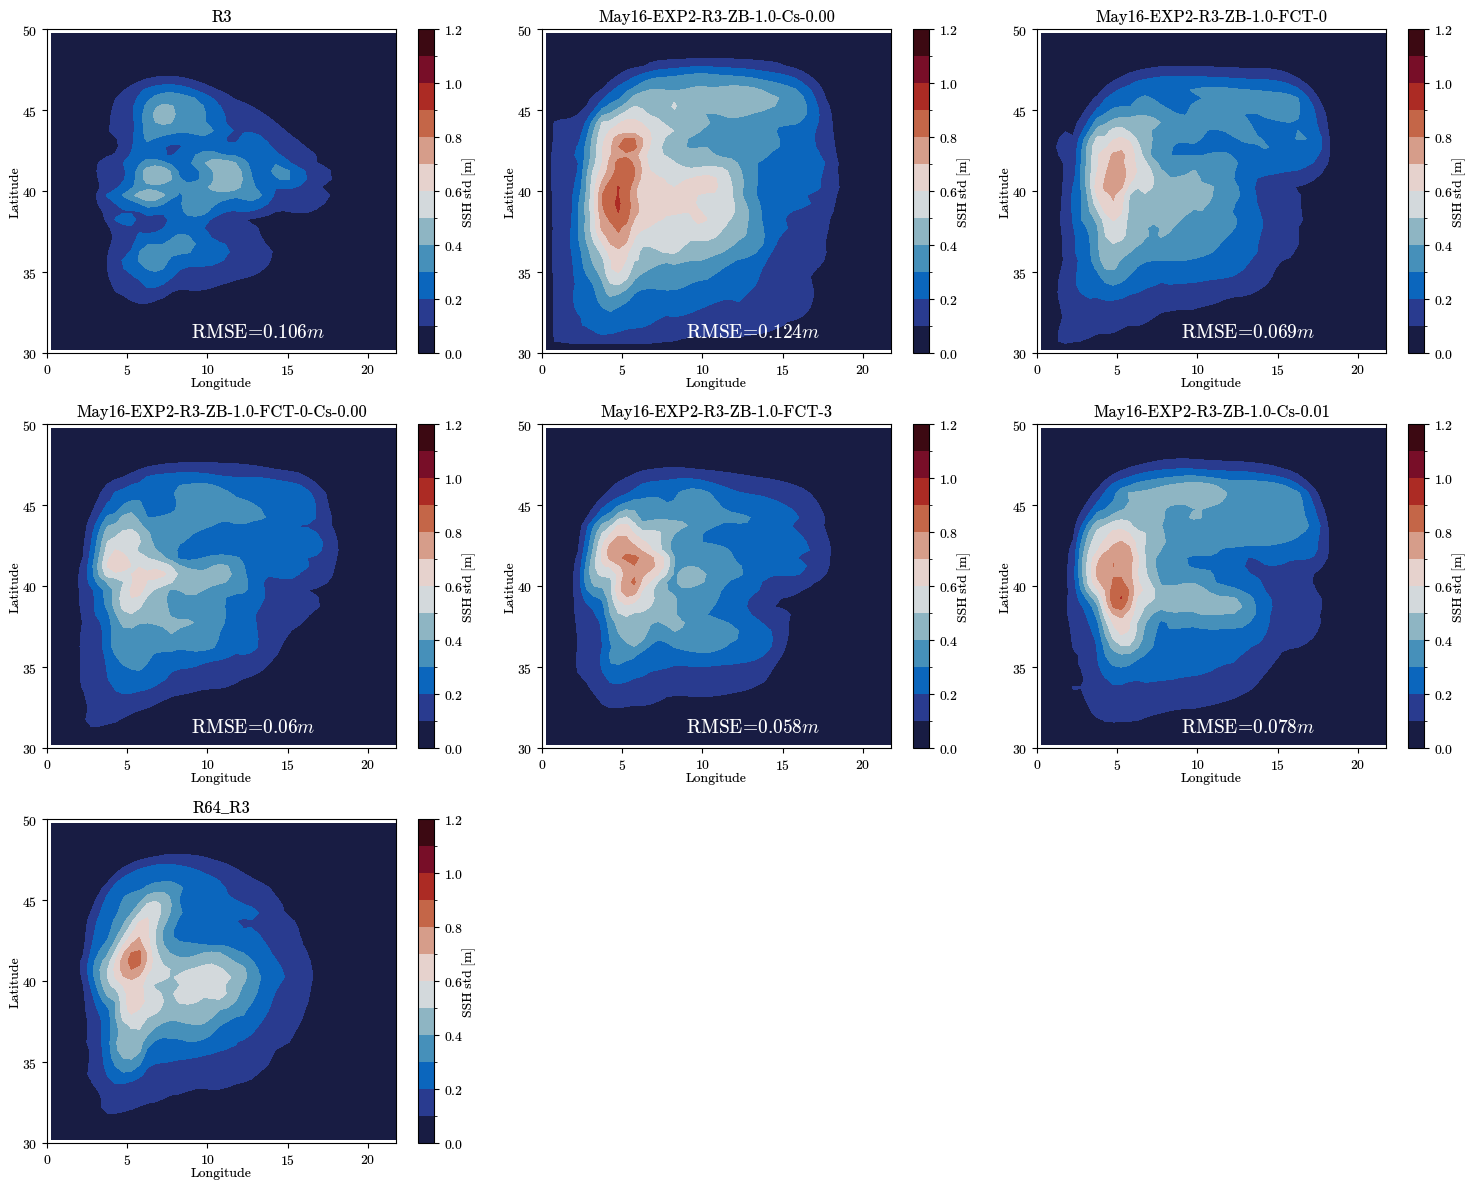

In [75]:
RR = 'R3'
exp = 'EXP2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh_std([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

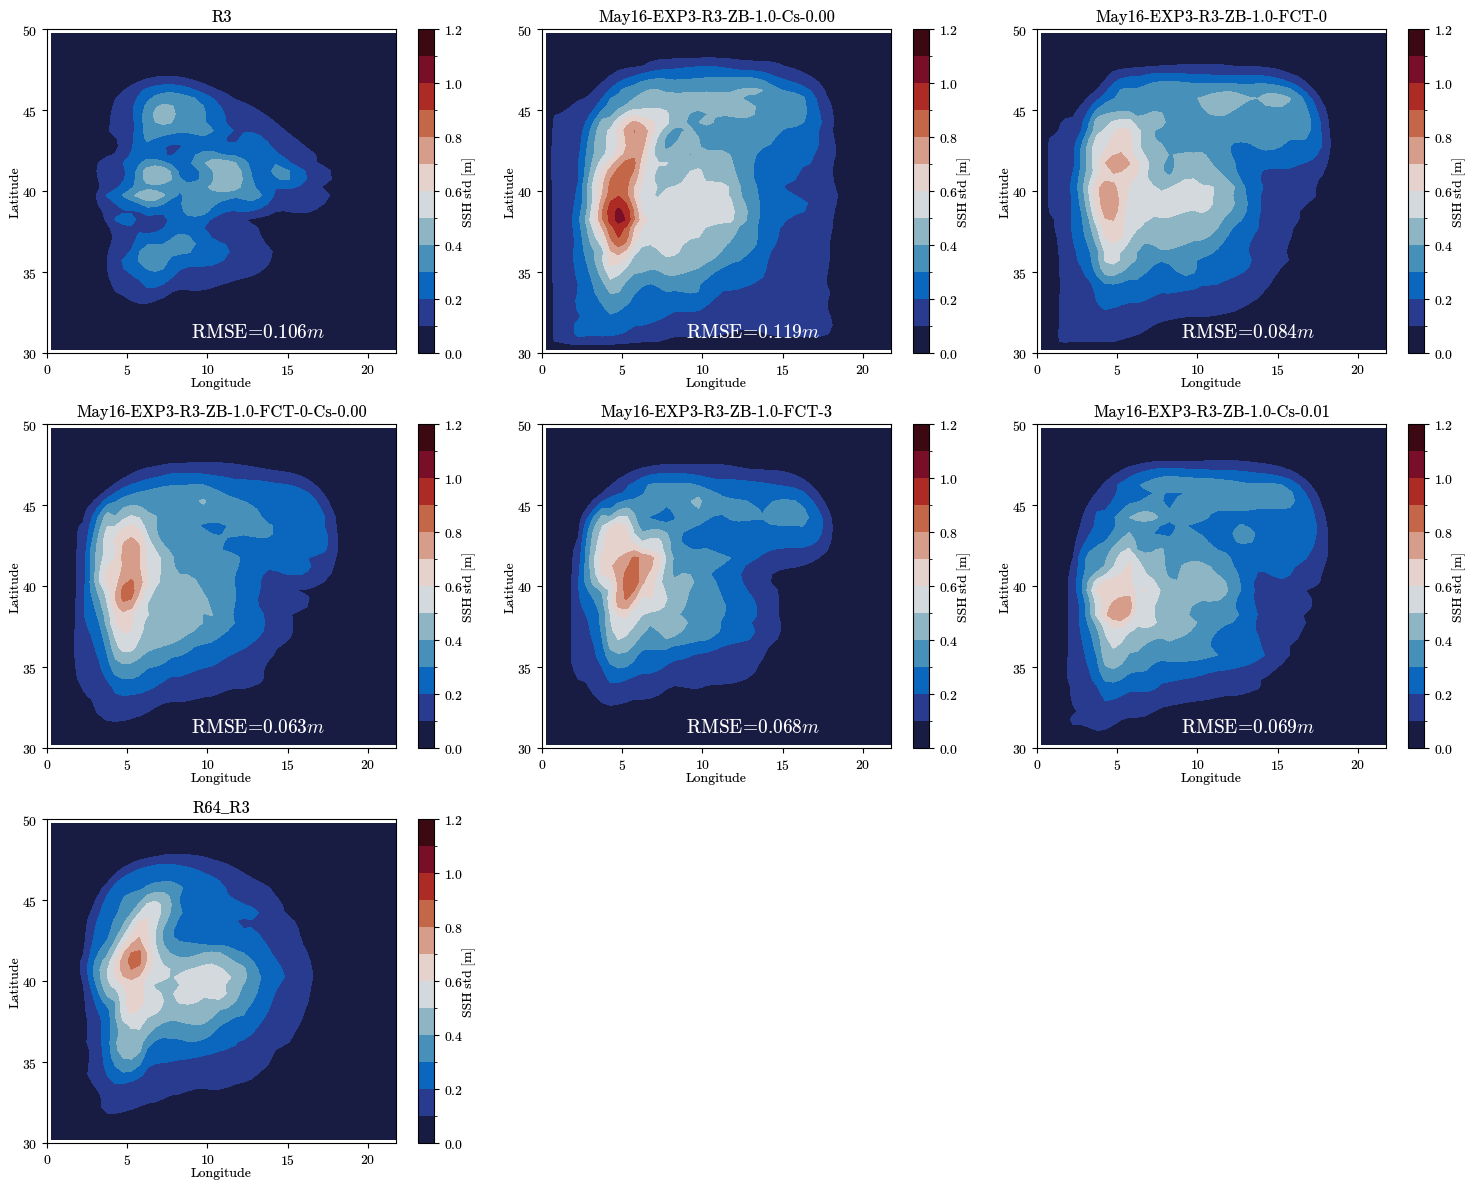

In [76]:
RR = 'R3'
exp = 'EXP3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh_std([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

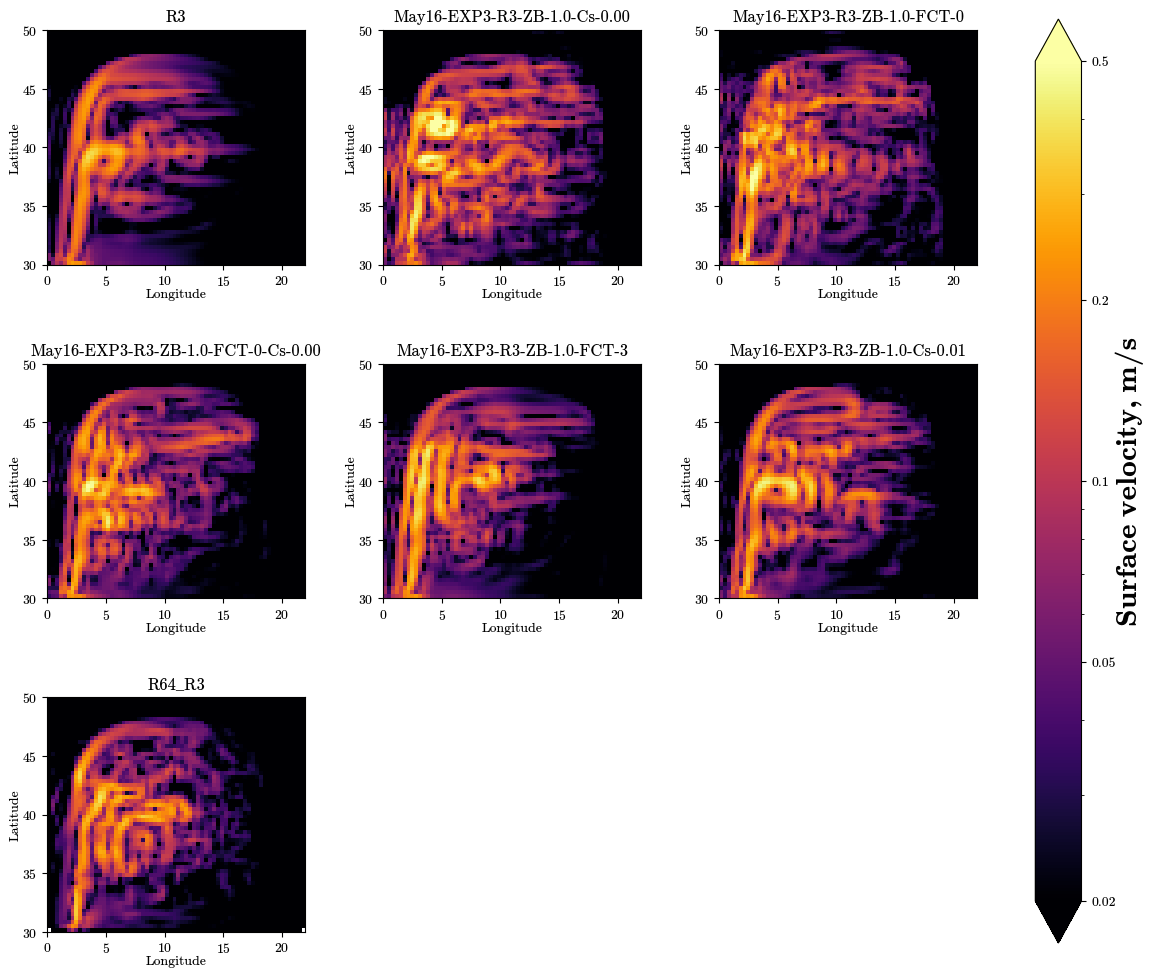

In [77]:
RR = 'R3'
exp = 'EXP3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_velocity_snapshot([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

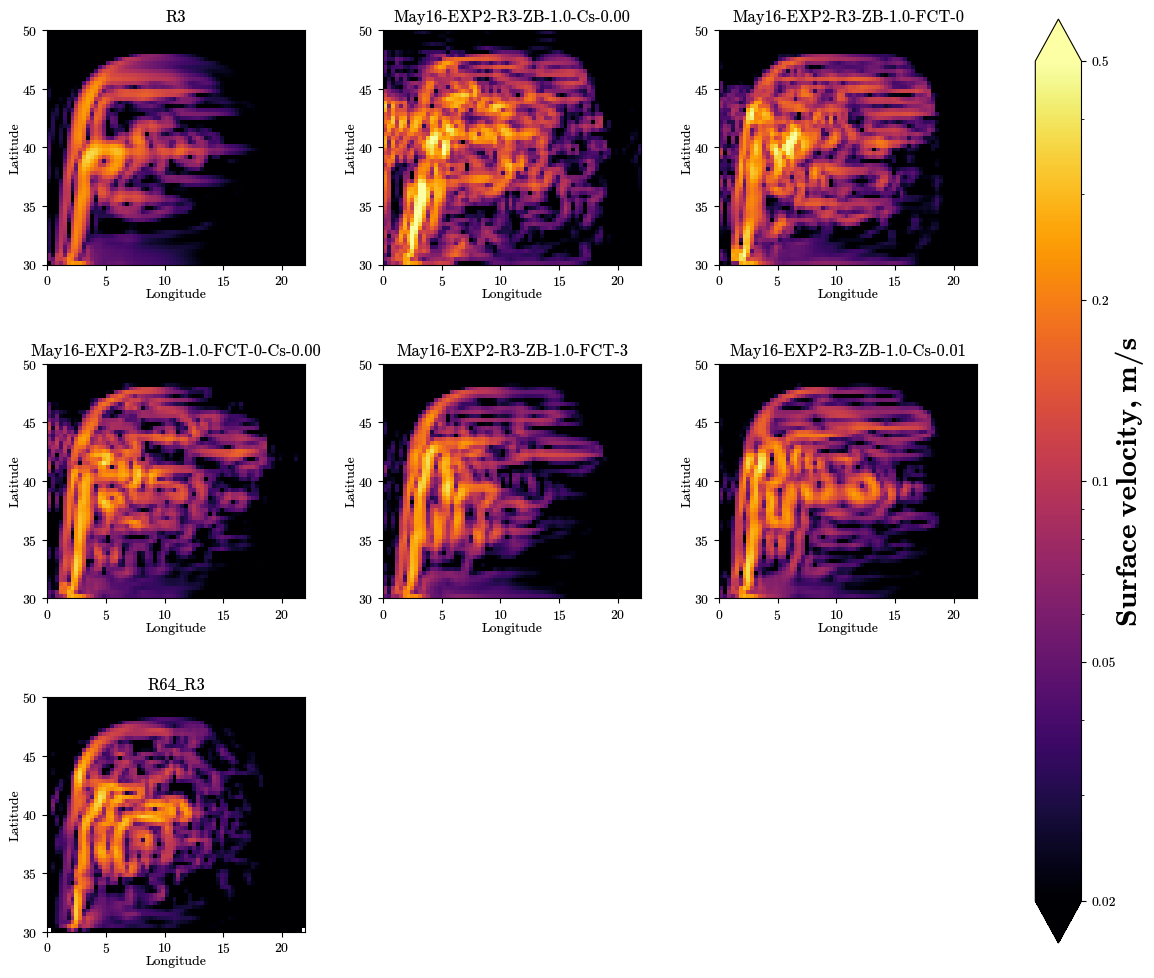

In [78]:
RR = 'R3'
exp = 'EXP2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_velocity_snapshot([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

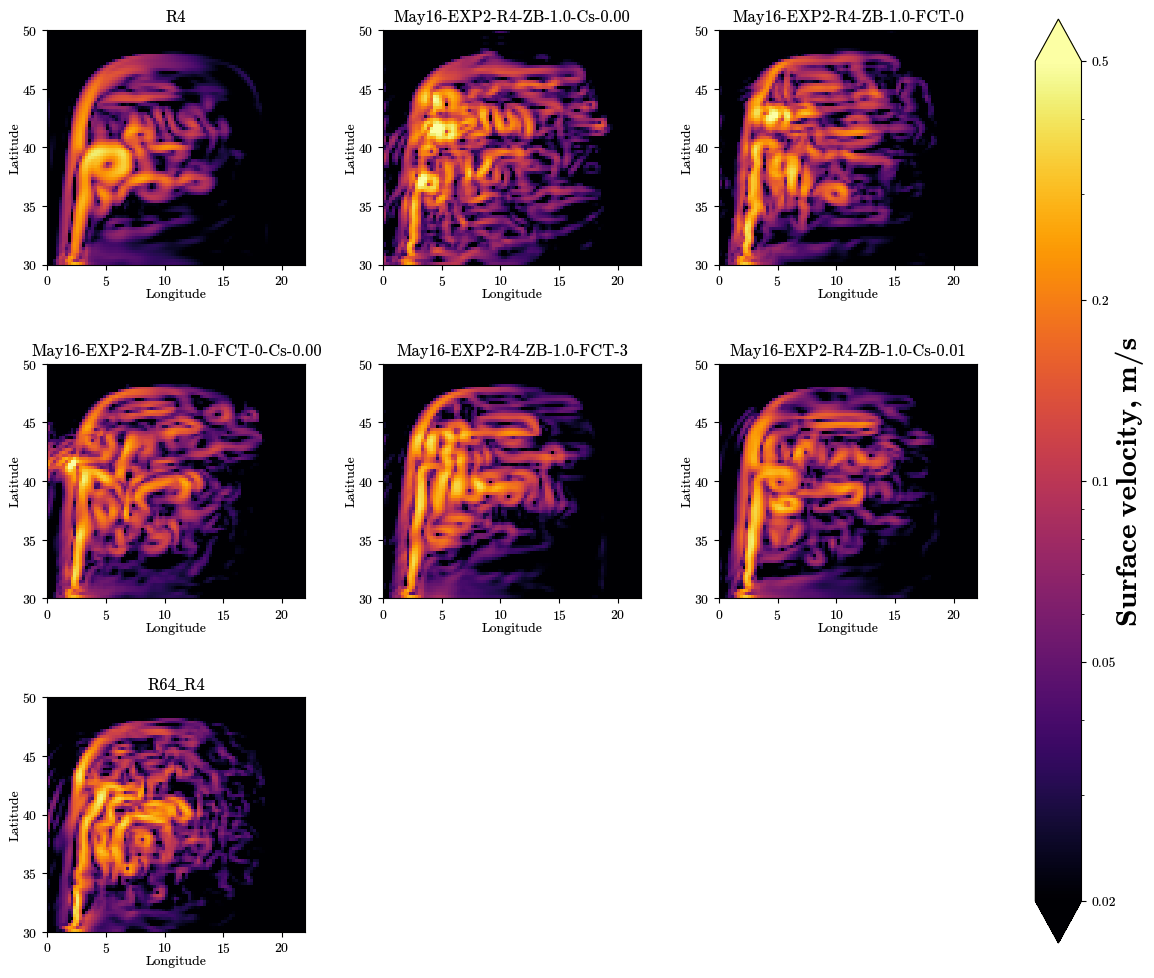

In [79]:
RR = 'R4'
exp = 'EXP2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_velocity_snapshot([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

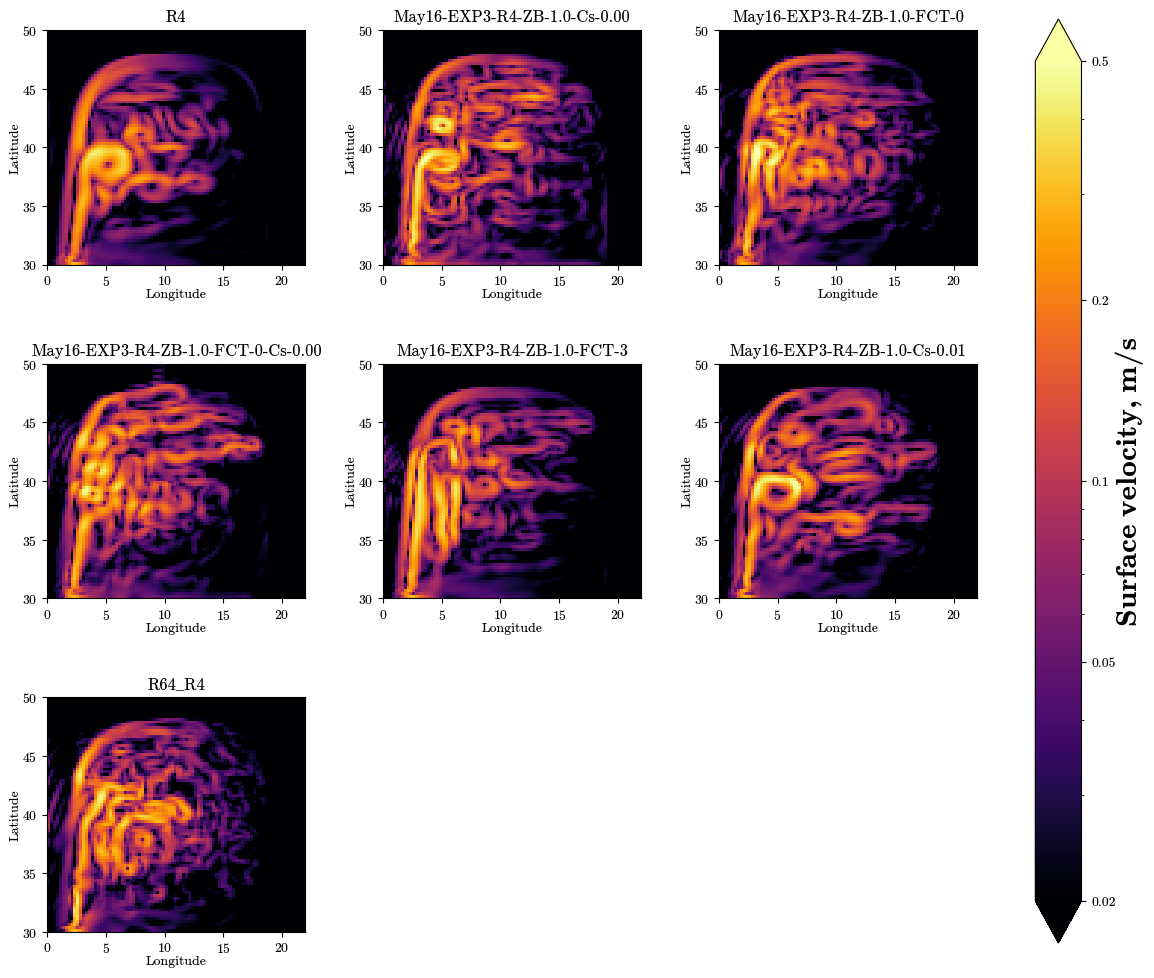

In [80]:
RR = 'R4'
exp = 'EXP3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_velocity_snapshot([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

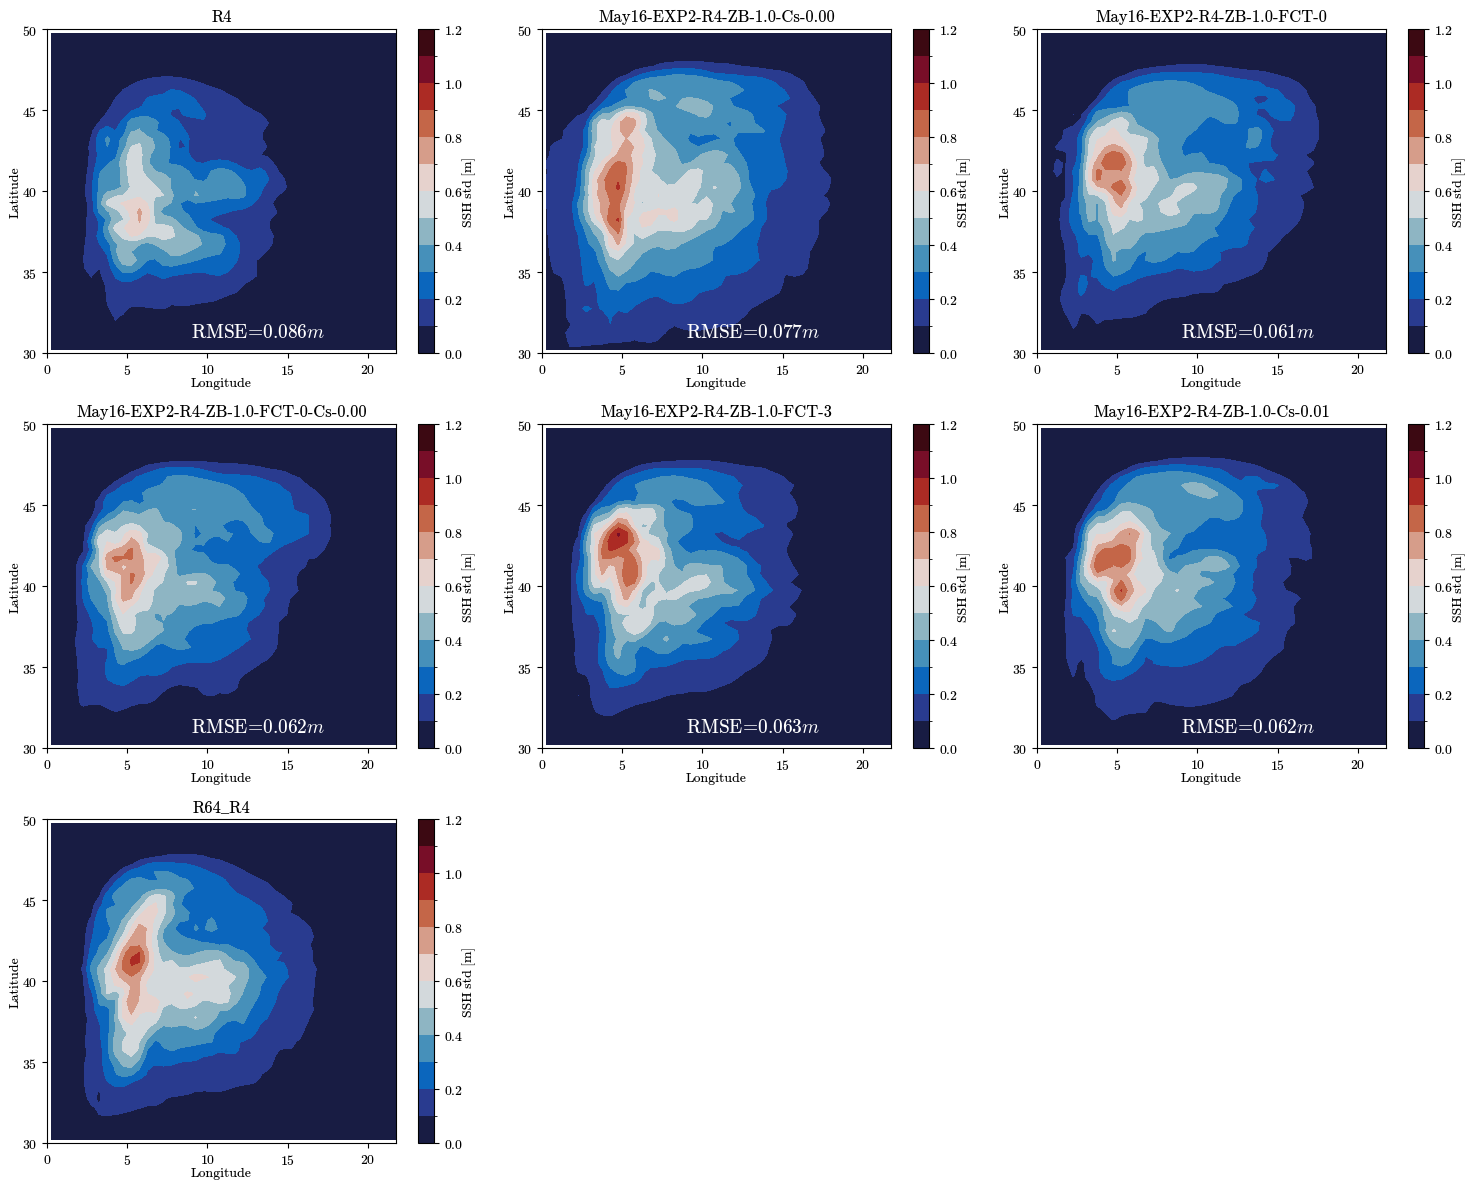

In [81]:
RR = 'R4'
exp = 'EXP2'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh_std([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

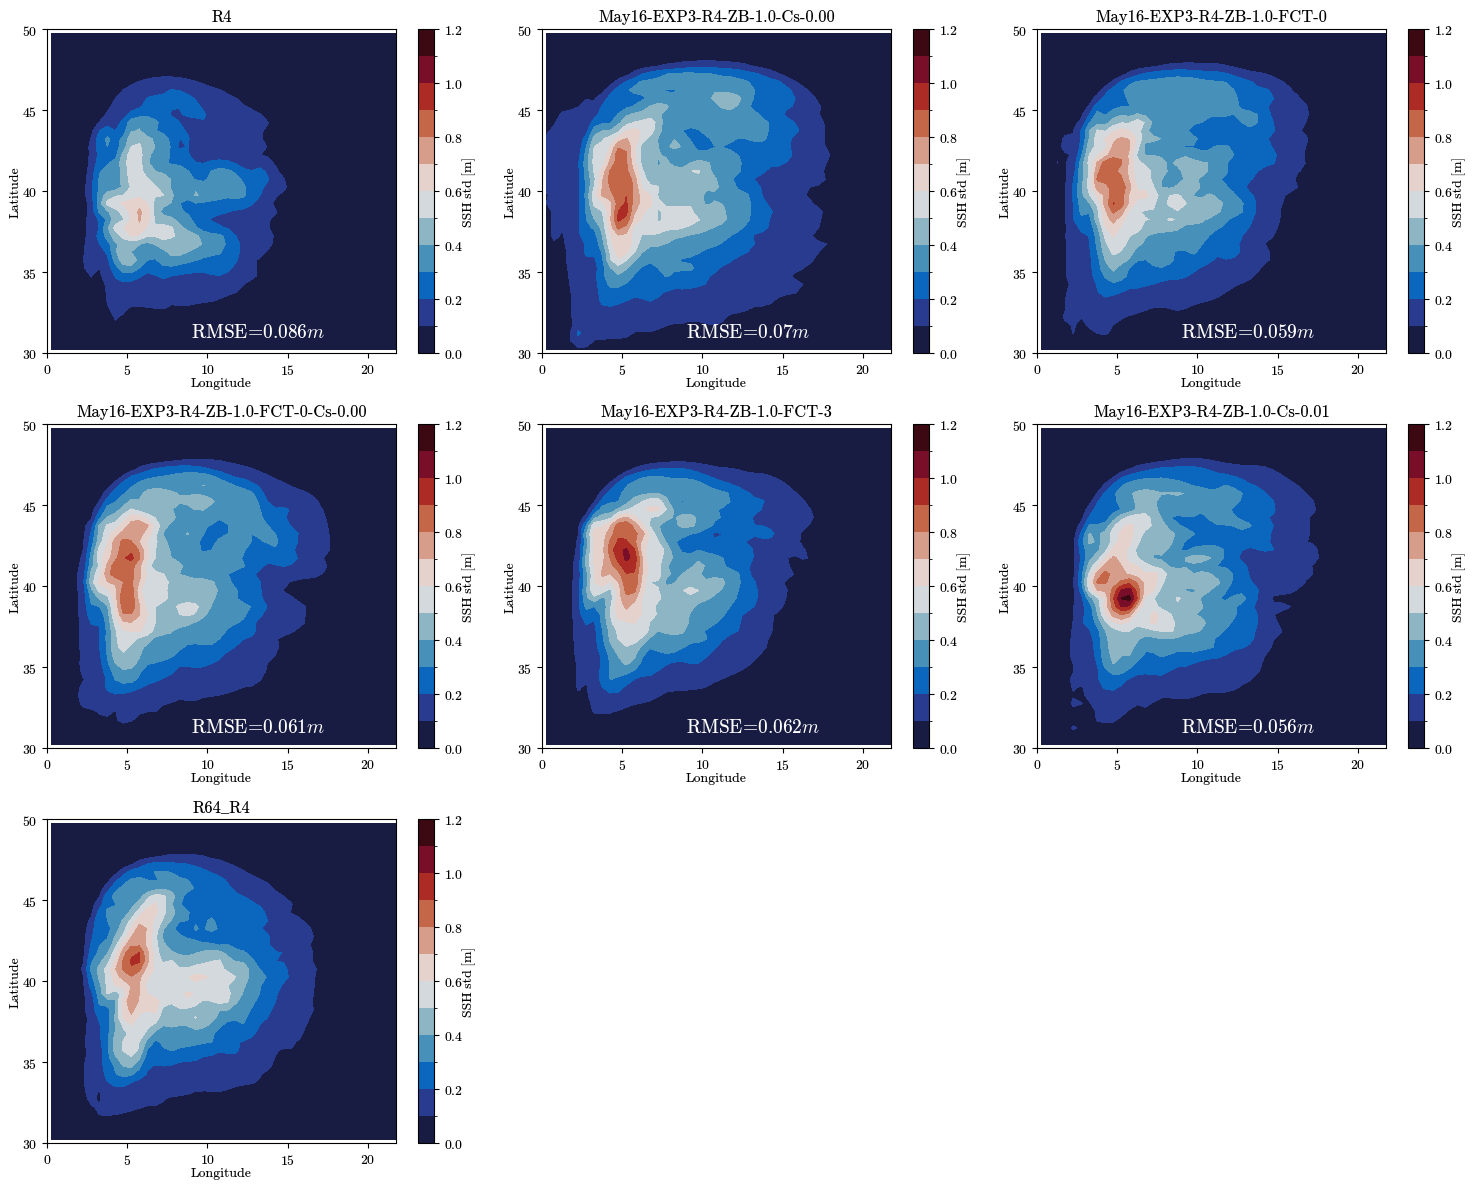

In [82]:
RR = 'R4'
exp = 'EXP3'
default_rcParams({'font.size': 10, 'figure.subplot.wspace': 0.4, 'figure.subplot.hspace': 0.1})
ds.plot_ssh_std([RR, 
                     #f'May16-{exp}-{RR}-ZB-1.0-inviscid', 
                     f'May16-{exp}-{RR}-ZB-1.0-Cs-0.00',
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-0', f'May16-{exp}-{RR}-ZB-1.0-FCT-0-Cs-0.00', 
                     f'May16-{exp}-{RR}-ZB-1.0-FCT-3', f'May16-{exp}-{RR}-ZB-1.0-Cs-0.01', 
                     f'R64_{RR}']);

# Summary

It is difficult to make a good choice but I choose EXP3 + FCT-0. There are few reasons:
* It is the least dissipative at the limit of coarse resolution.
* It provides reliable bound on norm of solution.
* It is applied more accurately than the FCT-3 limiter (which is noisy without background diffusion)
* Compared to FCT-3, there is saturation of dissipative properties at coarse resolution.
* It's energetic properties + stability may be a big benefit for NW2.
* I choose EXP3 but not EXP2 because:
  * For all regulartizations, mean SSH is better for EXP3 so it is better calibrated a priori
  * Without viscosity it is more stable at coarse resolutions and shows more uniform performance at high resolutions